Semeval2026_task13_Subtask B: Multi-Class Authorship Detection

This notebook builds **from scratch** a full pipeline for Subtask B (multi-class authorship detection) using:

1. A **baseline** TF–IDF + Linear SVM model  
2. Two **transformer models**:
   - Roberta-base
   - CodeT5-small

3.Combined ensemble (RoBERTa + CodeT5 + SVM → super strong)

The task: given a code snippet, predict which of the 11 author families wrote it (1 human + 10 LLM families).

## 1. Imports and Global Configuration

In [ ]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. Load Parquet Data and Quick Sanity Checks

In [ ]:
import pandas as pd
import numpy as np

# Load data (letting Pandas choose the default engine, usually pyarrow)
train = pd.read_parquet("task_b_training_set.parquet")
validation = pd.read_parquet("task_b_validation_set.parquet")
test = pd.read_parquet("task_b_test_set_sample.parquet")

# Define _df versions for consistency throughout the notebook
train_df = train.copy()
val_df = validation.copy()
test_df = test.copy()

# Author families (11 classes)
FAMILIES = [
    "human",
    "deepseek-ai",
    "qwen",
    "01-ai",
    "bigcode",
    "gemma",
    "phi",
    "meta-llama",
    "ibm-granite",
    "mistral",
    "openai",
]

label2name = {i: name for i, name in enumerate(FAMILIES)}
name2label = {name: i for i, name in enumerate(FAMILIES)}

NUM_LABELS = len(FAMILIES)
print("Num labels:", NUM_LABELS)
print(label2name)

Num labels: 11
{0: 'human', 1: 'deepseek-ai', 2: 'qwen', 3: '01-ai', 4: 'bigcode', 5: 'gemma', 6: 'phi', 7: 'meta-llama', 8: 'ibm-granite', 9: 'mistral', 10: 'openai'}


In [ ]:
#a quick overview of the columns, dtypes, and sizes of each split.

print("=== Shapes ===")
print("Train shape      :", train.shape)
print("Validation shape :", validation.shape)
print("Test shape       :", test.shape)


print("\n=== Train Info ===")
train.info()

print("\n=== First 5 rows of train ===")
display(train.head())

=== Shapes ===
Train shape      : (500000, 4)
Validation shape : (100000, 4)
Test shape       : (1000, 4)

=== Train Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   code       500000 non-null  object
 1   generator  500000 non-null  object
 2   label      500000 non-null  int64 
 3   language   500000 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB

=== First 5 rows of train ===


,code,generator,label,language
0,"def load(config, filepath, token):\n if con...",Human,0,Python
1,"n = int(input())\narr = list(map(int, input()....",Human,0,Python
2,using Aow.Infrastructure.Domain;\nusing Aow.In...,GPT-4o,10,C#
3,"def save_data(bot, force=False):\n if bot.d...",Human,0,Python
4,"def parse_metadata(metaurl, progress=1e5):\n ...",Human,0,Python


In [ ]:
#Quick schema / column names check

print("Train columns      :", train.columns.tolist())
print("Validation columns :", validation.columns.tolist())
print("Test columns       :", test.columns.tolist())



Train columns      : ['code', 'generator', 'label', 'language']
Validation columns : ['code', 'generator', 'label', 'language']
Test columns       : ['code', 'generator', 'label', 'language']


In [ ]:
#Basic descriptive statistics for non-text columns

print("Train describe (numeric columns):")
display(train.describe(include=[np.number]))

print("\nTrain describe (all columns):")
display(train.describe(include="all"))


Train describe (numeric columns):


,label
count,500000.000000
mean,0.713296
std,2.228028
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,10.000000



Train describe (all columns):


,code,generator,label,language
count,500000,500000,500000.000000,500000
unique,500000,31,NaN,8
top,class MinidumpUploadRetry implements NetworkCh...,Human,NaN,Java
freq,1,442096,NaN,137076
mean,NaN,NaN,0.713296,NaN
std,NaN,NaN,2.228028,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,0.000000,NaN
50%,NaN,NaN,0.000000,NaN
75%,NaN,NaN,0.000000,NaN


In [ ]:
#Explore class balance; very important for modeling and baseline choice.

# Train label distribution
print("Train label counts:")
display(train['label'].value_counts())

print("\nTrain label percentages:")
display(train['label'].value_counts(normalize=True) * 100)

# Validation label distribution (if labeled)
if 'label' in validation.columns:
    print("\nValidation label counts:")
    display(validation['label'].value_counts())
    print("\nValidation label percentages:")
    display(validation['label'].value_counts(normalize=True) * 100)

Train label counts:


,count
label,
0,442096
10,10810
2,8993
7,8197
8,8127
6,5783
9,4608
1,4162
3,3029



Train label percentages:


,proportion
label,
0,88.4192
10,2.1620
2,1.7986
7,1.6394
8,1.6254
6,1.1566
9,0.9216
1,0.8324
3,0.6058



Validation label counts:


,count
label,
0,88490
10,2154
2,1755
7,1695
8,1579
6,1118
9,895
1,847
3,650



Validation label percentages:


,proportion
label,
0,88.490
10,2.154
2,1.755
7,1.695
8,1.579
6,1.118
9,0.895
1,0.847
3,0.650


In [ ]:
# Quick info
print("\nData types and non-null counts:")
print(train_df.info())

# Missing values per column
print("\nMissing values per column:")
print(train_df.isna().sum())




Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   code       500000 non-null  object
 1   generator  500000 non-null  object
 2   label      500000 non-null  int64 
 3   language   500000 non-null  object
dtypes: int64(1), object(3)
memory usage: 15.3+ MB
None

Missing values per column:
code         0
generator    0
label        0
language     0
dtype: int64


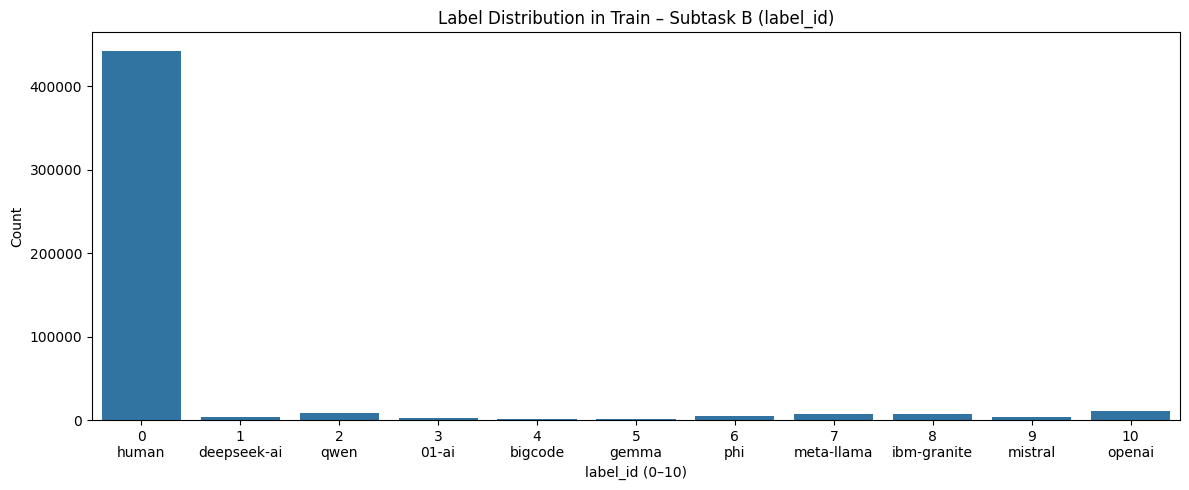

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(
    data=train_df,
    x="label"
)
plt.title("Label Distribution in Train – Subtask B (label_id)")
plt.xlabel("label_id (0–10)")
plt.ylabel("Count")
plt.xticks(
    ticks=range(len(FAMILIES)),
    labels=[f"{i}\n{fam}" for i, fam in enumerate(FAMILIES)],
    rotation=0
)
plt.tight_layout()
plt.show()

Code length stats:


,code_len
count,500000.000000
mean,1409.680092
std,1662.323179
min,24.000000
25%,432.000000
50%,812.000000
75%,1675.000000
max,34346.000000


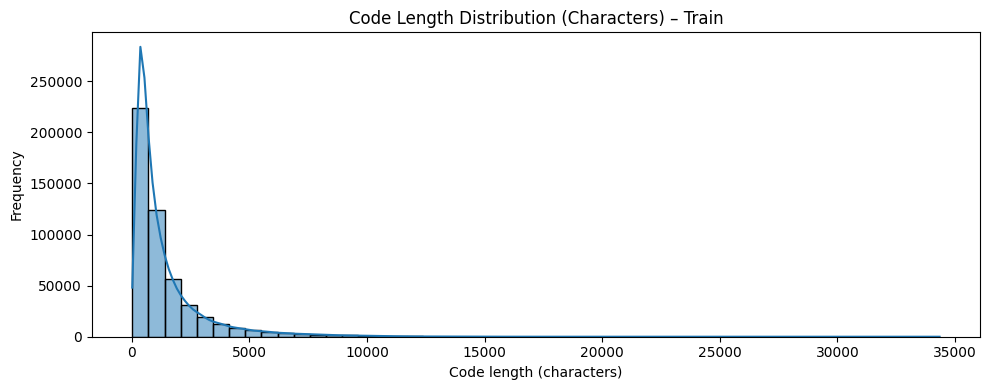

In [ ]:
TEXT_COL = "code" # Define TEXT_COL

# Add code length column (number of characters)
train_df["code_len"] = train_df[TEXT_COL].astype(str).str.len()

print("Code length stats:")
display(train_df["code_len"].describe())

plt.figure(figsize=(10, 4))
sns.histplot(train_df["code_len"], bins=50, kde=True)
plt.title("Code Length Distribution (Characters) – Train")
plt.xlabel("Code length (characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [ ]:
# Ensure fastparquet is installed for reading parquet files
!pip install fastparquet

Code length stats:


,code_len
count,500000.000000
mean,1409.680092
std,1662.323179
min,24.000000
25%,432.000000
50%,812.000000
75%,1675.000000
max,34346.000000


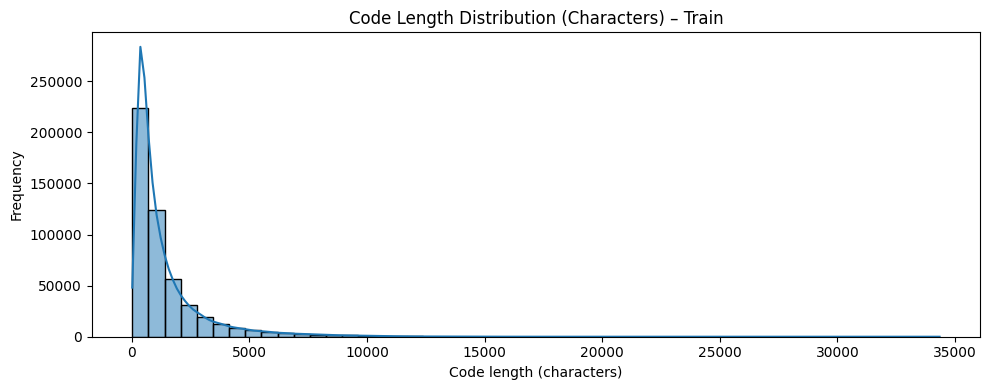

In [ ]:
# Add code length column (number of characters)
train_df["code_len"] = train_df[TEXT_COL].astype(str).str.len()
# Add family name column for plotting consistency with FAMILIES list
train_df["family_name"] = train_df["label"].map(label2name)

print("Code length stats:")
display(train_df["code_len"].describe())

plt.figure(figsize=(10, 4))
sns.histplot(train_df["code_len"], bins=50, kde=True)
plt.title("Code Length Distribution (Characters) – Train")
plt.xlabel("Code length (characters)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Token length stats:


,token_len
count,500000.000000
mean,127.868310
std,150.739021
min,1.000000
25%,41.000000
50%,75.000000
75%,150.000000
max,3297.000000


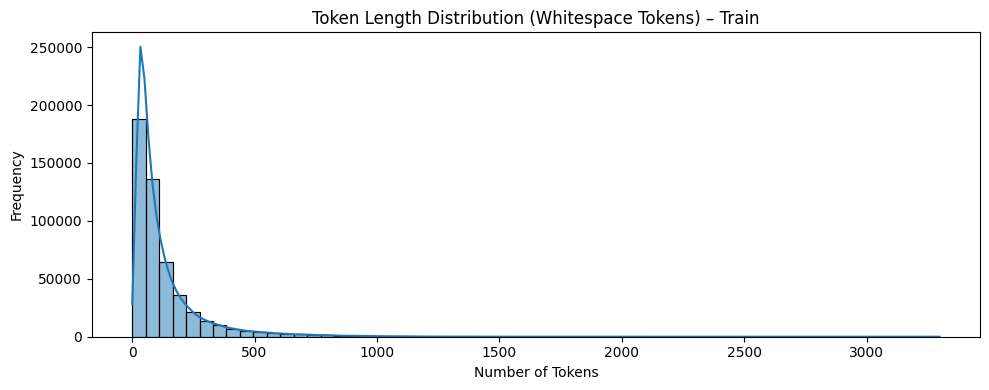

In [ ]:
# Code length in TOKENS (whitespace-based)
train_df["token_len"] = train_df[TEXT_COL].astype(str).apply(lambda x: len(x.split()))

print("Token length stats:")
display(train_df["token_len"].describe())

plt.figure(figsize=(10, 4))
sns.histplot(train_df["token_len"], bins=60, kde=True)
plt.title("Token Length Distribution (Whitespace Tokens) – Train")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


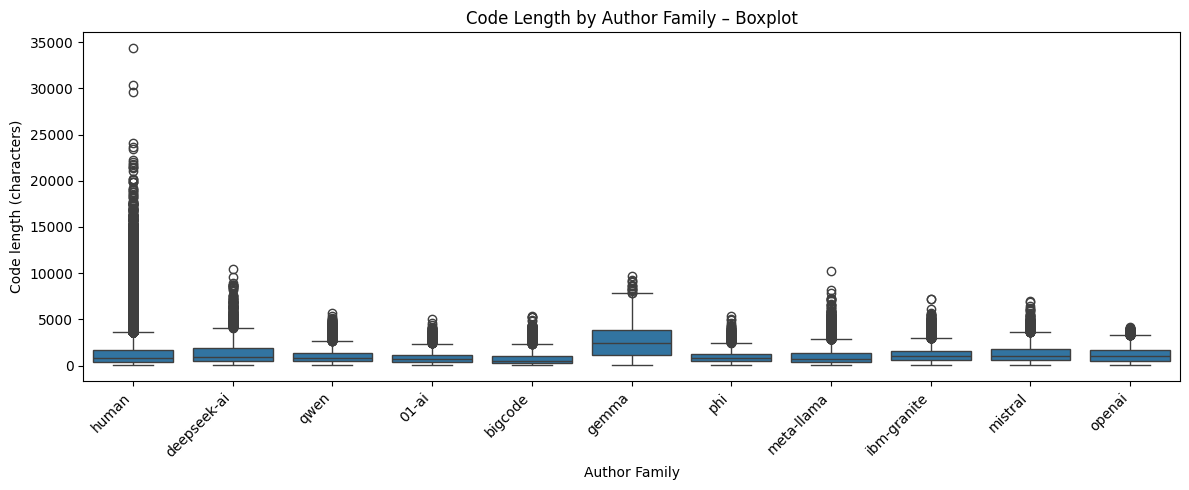

In [ ]:
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=train_df,
    x="family_name", # Use the new consistent column
    y="code_len",
    order=FAMILIES
)
plt.title("Code Length by Author Family – Boxplot")
plt.xlabel("Author Family")
plt.ylabel("Code length (characters)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
label_counts = (
    train_df["label"]
    .value_counts()
    .reindex(FAMILIES)
    .rename("count")
    .to_frame()
)

label_counts["percentage"] = (
    label_counts["count"] / len(train_df) * 100
).round(2)

print("Label distribution table (Train):")
display(label_counts)

Label distribution table (Train):


,count,percentage
label,,
human,NaN,NaN
deepseek-ai,NaN,NaN
qwen,NaN,NaN
01-ai,NaN,NaN
bigcode,NaN,NaN
gemma,NaN,NaN
phi,NaN,NaN
meta-llama,NaN,NaN
ibm-granite,NaN,NaN


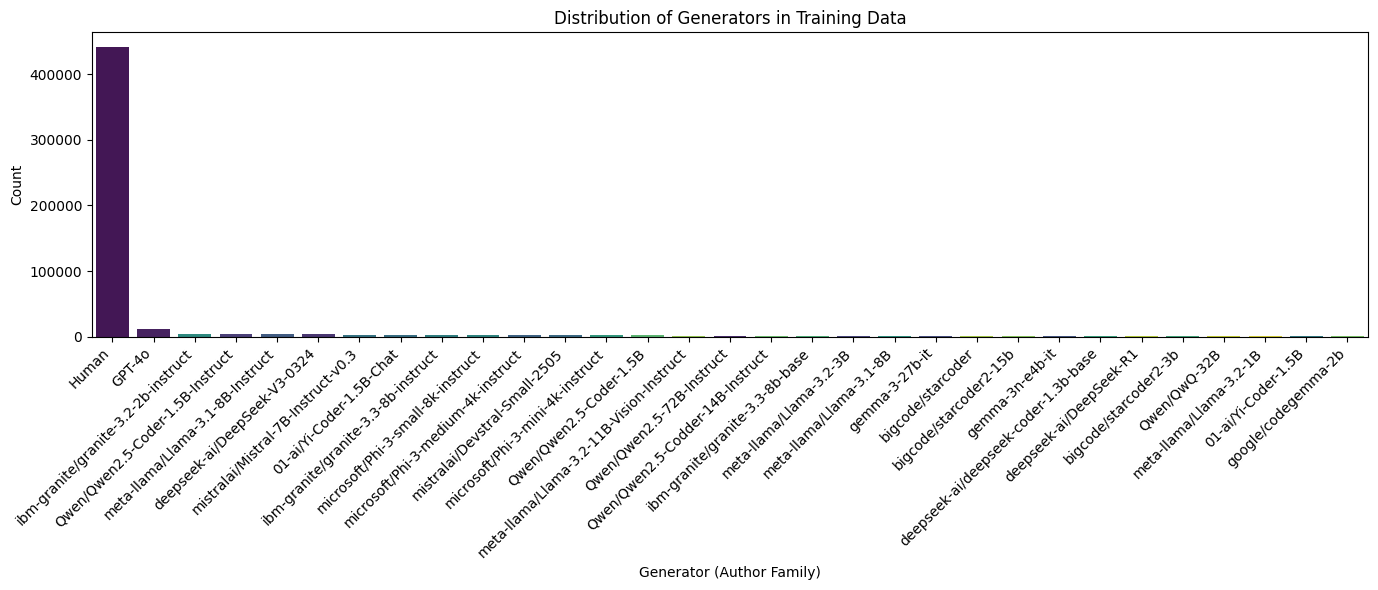

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(
    data=train_df,
    x="generator",
    order=train_df['generator'].value_counts().index,
    palette='viridis',
    hue="generator",  # Assign x to hue
    legend=False      # Suppress legend if not needed
)
plt.title("Distribution of Generators in Training Data")
plt.xlabel("Generator (Author Family)")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

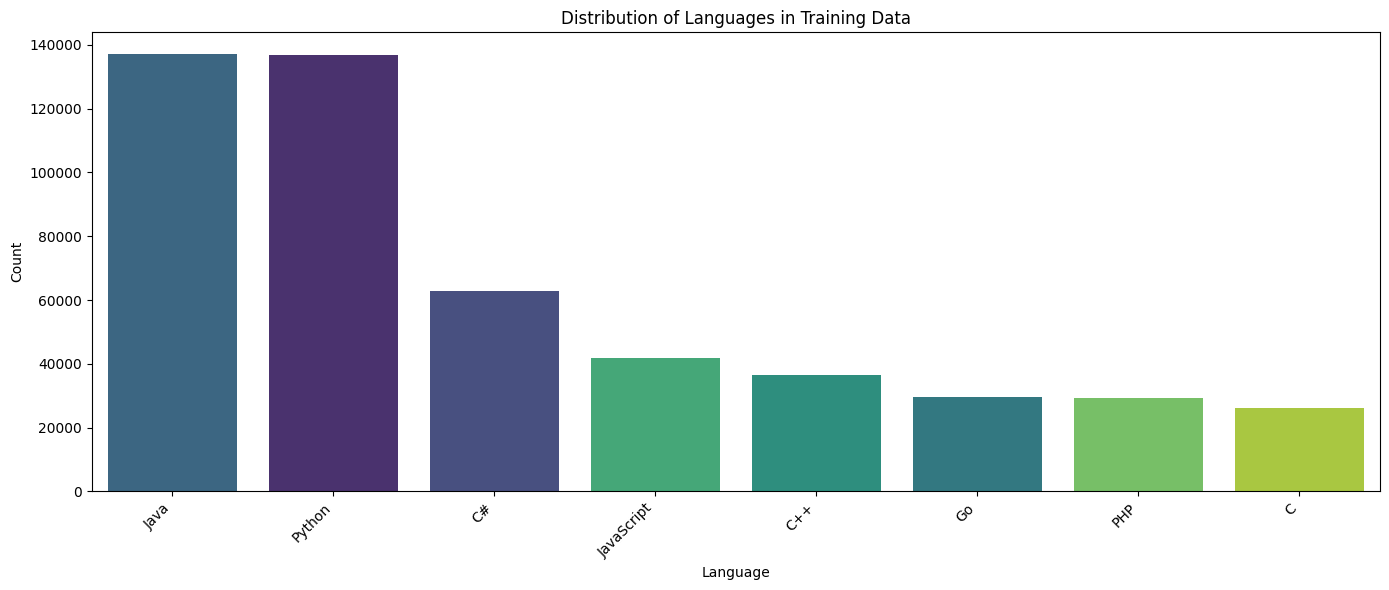

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(
    data=train_df,
    x="language",
    order=train_df['language'].value_counts().index,
    palette='viridis',
    hue="language",  # Assign x to hue
    legend=False      # Suppress legend if not needed
)
plt.title("Distribution of Languages in Training Data")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

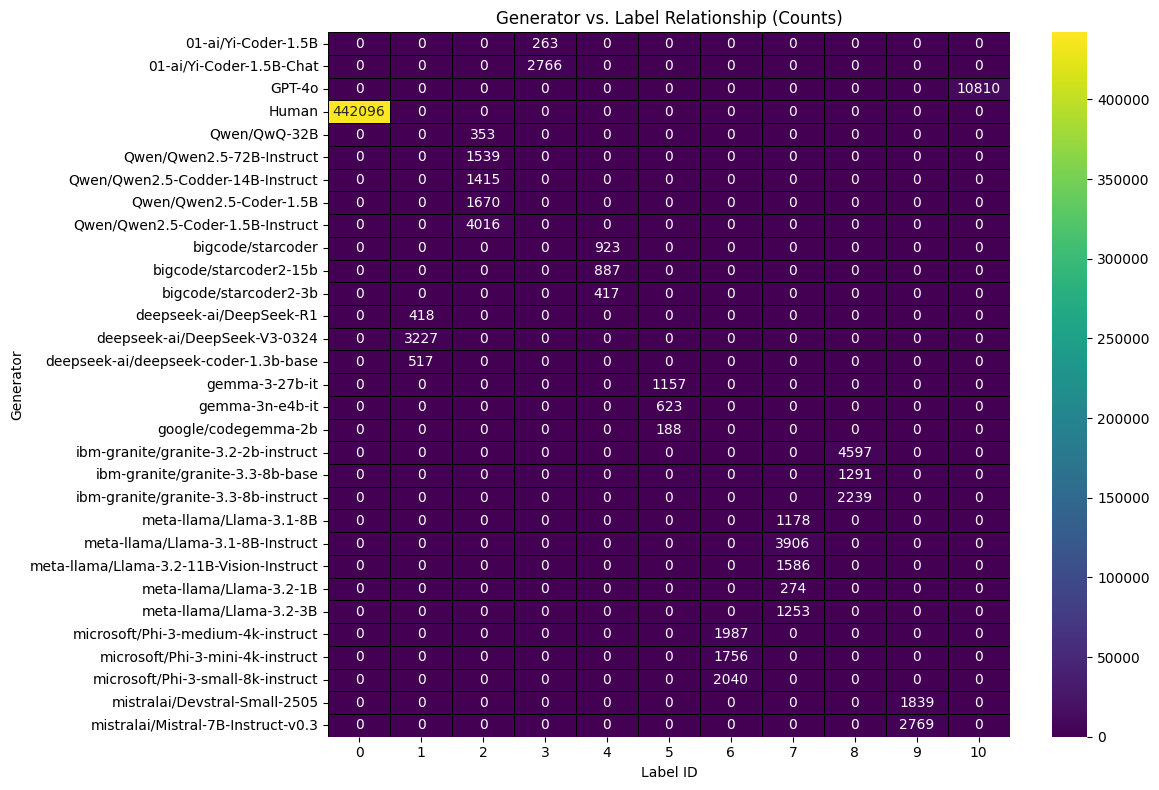

In [ ]:
cross_tab = pd.crosstab(train_df['generator'], train_df['label'])

plt.figure(figsize=(12, 8))
sns.heatmap(
    cross_tab,
    annot=True,
    fmt="d",
    cmap="viridis",
    linewidths=.5,
    linecolor='black'
)
plt.title("Generator vs. Label Relationship (Counts)")
plt.xlabel("Label ID")
plt.ylabel("Generator")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import random

# --- Start of fix: Ensure dataframes and constants are defined for standalone execution ---
# Load parquet files (assuming they are in the same directory)
train = pd.read_parquet("task_b_training_set.parquet")
validation = pd.read_parquet("task_b_validation_set.parquet")
test = pd.read_parquet("task_b_test_set_sample.parquet")

# Define _df versions for consistency throughout the notebook
train_df = train.copy()
val_df = validation.copy()
test_df = test.copy()

# Author families (11 classes)
FAMILIES = [
    "human",
    "deepseek-ai",
    "qwen",
    "01-ai",
    "bigcode",
    "gemma",
    "phi",
    "meta-llama",
    "ibm-granite",
    "mistral",
    "openai",
]

label2name = {i: name for i, name in enumerate(FAMILIES)}
name2label = {name: i for i, name in enumerate(FAMILIES)}

NUM_LABELS = len(FAMILIES)

# SEED is typically defined globally, adding a fallback here for standalone execution
try:
    SEED # Check if SEED is already defined
except NameError:
    SEED = 42 # Define if not already present
random.seed(SEED) # Ensure random state is set for sampling
np.random.seed(SEED)
# --- End of fix ---

print("=== Qualitative Peek Table: Human vs. LLM Code Samples ===\n")

sampled_data = []

# Get one human sample
human_sample_row = train_df[train_df['generator'] == 'Human'].sample(1, random_state=SEED).iloc[0]
sampled_data.append({
    'Generator': human_sample_row['generator'],
    'Family Name': label2name[human_sample_row['label']],
    'Label ID': human_sample_row['label'],
    'Code Snippet': human_sample_row['code'][:200] + ('...' if len(human_sample_row['code']) > 200 else '')
})

# Get one sample from each LLM family
llm_families = [fam for fam in FAMILIES if fam != 'human'] # Exclude 'human' from this list

for fam_name in llm_families:
    label_id = name2label[fam_name]
    llm_sample_row = train_df[train_df['label'] == label_id].sample(1, random_state=SEED).iloc[0]
    sampled_data.append({
        'Generator': llm_sample_row['generator'],
        'Family Name': label2name[llm_sample_row['label']],
        'Label ID': llm_sample_row['label'],
        'Code Snippet': llm_sample_row['code'][:200] + ('...' if len(llm_sample_row['code']) > 200 else '')
    })

qualitative_samples_df = pd.DataFrame(sampled_data)
display(qualitative_samples_df)

=== Qualitative Peek Table: Human vs. LLM Code Samples ===



,Generator,Family Name,Label ID,Code Snippet
0,Human,human,0,public class PlayOptions {\n private String...
1,deepseek-ai/deepseek-coder-1.3b-base,deepseek-ai,1,"n, q = map(int, input().split())\na = list(map..."
2,Qwen/QwQ-32B,qwen,2,namespace dodSON.Core.Networking\n{\n /// <...
3,01-ai/Yi-Coder-1.5B,01-ai,3,import org.junit.jupiter.api.Test;\nimport org...
4,bigcode/starcoder,bigcode,4,\n# Author: <NAME>\n# Ascending order scale wh...
5,google/codegemma-2b,gemma,5,\nnamespace RecipeApi\n{\n public class Web...
6,microsoft/Phi-3-mini-4k-instruct,phi,6,// Assuming CKAN API URL and API key are confi...
7,meta-llama/Llama-3.2-11B-Vision-Instruct,meta-llama,7,/**\n * The CreateCl opcode is specified as no...
8,ibm-granite/granite-3.2-2b-instruct,ibm-granite,8,public OntList createOnlistFromIterable(OntGra...
9,mistralai/Mistral-7B-Instruct-v0.3,mistral,9,"from simuLAB.Core import BlockVector, Joint, T..."


## 4. Baseline Model: TF–IDF + Linear SVM


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score

# --- Start of fix: Ensure dataframes and constants are defined for standalone execution ---
# Load parquet files (assuming they are in the same directory)
try:
    train_df
    val_df
    test_df
except NameError:
    try:
        print("Loading data...")
        # Using standard pyarrow engine (default)
        train = pd.read_parquet("task_b_training_set.parquet")
        validation = pd.read_parquet("task_b_validation_set.parquet")
        test = pd.read_parquet("task_b_test_set_sample.parquet")

        train_df = train.copy()
        val_df = validation.copy()
        test_df = test.copy()
    except Exception as e:
        print("\n" + "="*60)
        print("CRITICAL ERROR: Could not load the dataset.")
        print(f"Specific error: {e}")
        print("="*60)
        print("ACTION REQUIRED:")
        print("1. The file 'task_b_training_set.parquet' (or others) appears to be corrupted.")
        print("2. Please DELETE the file from the Colab 'Files' pane on the left.")
        print("3. RE-UPLOAD a fresh, valid copy of the file.")
        print("="*60 + "\n")
        # Stop execution here since we can't proceed without data
        raise e

# Author families (11 classes)
FAMILIES = [
    "human",
    "deepseek-ai",
    "qwen",
    "01-ai",
    "bigcode",
    "gemma",
    "phi",
    "meta-llama",
    "ibm-granite",
    "mistral",
    "openai",
]

label2name = {i: name for i, name in enumerate(FAMILIES)}
name2label = {name: i for i, name in enumerate(FAMILIES)}

NUM_LABELS = len(FAMILIES)
# --- End of fix ---

# Prepare text and labels
X_train_text = train_df["code"].astype(str).values
y_train = train_df["label"].values # Corrected from 'family_label'

X_val_text = val_df["code"].astype(str).values
y_val = val_df["label"].values     # Corrected from 'family_label'

print("Number of training samples:", len(X_train_text))
print("Number of validation samples:", len(X_val_text))

# TF–IDF over character n-grams (good for code)
tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    max_features=100_000,
    min_df=2,
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf = tfidf.transform(X_val_text)

print("TF–IDF train shape:", X_train_tfidf.shape)
print("TF–IDF val shape:", X_val_tfidf.shape)

Loading data...
Number of training samples: 500000
Number of validation samples: 100000
TF–IDF train shape: (500000, 100000)
TF–IDF val shape: (100000, 100000)


In [ ]:
# ============================================================
# TF-IDF + SVM baseline for Task B (11-class authorship)
# ============================================================

import os
import random
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# ----------------------------
# 1. Reproducibility
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ----------------------------
# 2. Load data
# ----------------------------
train_df = pd.read_parquet("task_b_training_set.parquet")
val_df   = pd.read_parquet("task_b_validation_set.parquet")
test_df  = pd.read_parquet("task_b_test_set_sample.parquet")

TEXT_COL  = "code"
LABEL_COL = "label"

FAMILIES = [
    "human", "deepseek-ai", "qwen", "01-ai", "bigcode", "gemma", "phi",
    "meta-llama", "ibm-granite", "mistral", "openai",
]
label2name = {i: name for i, name in enumerate(FAMILIES)}

print("Train shape:", train_df.shape)
print("Val shape  :", val_df.shape)
print("Test shape :", test_df.shape)

# ----------------------------
# 3. Prepare text & labels
# ----------------------------
X_train_text = train_df[TEXT_COL].astype(str).values
y_train      = train_df[LABEL_COL].values

X_val_text   = val_df[TEXT_COL].astype(str).values
y_val        = val_df[LABEL_COL].values

X_test_text  = test_df[TEXT_COL].astype(str).values

# ----------------------------
# 4. TF-IDF vectorizer (char n-grams)
# ----------------------------
print("Fitting TF-IDF vectorizer...")

tfidf = TfidfVectorizer(
    analyzer="char_wb",      # char n-grams at word boundaries
    ngram_range=(3, 6),
    min_df=3,
    max_features=400_000,
    sublinear_tf=True,
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_val_tfidf   = tfidf.transform(X_val_text)
X_test_tfidf  = tfidf.transform(X_test_text)

print("TF-IDF shapes:",
      X_train_tfidf.shape,
      X_val_tfidf.shape,
      X_test_tfidf.shape)

# ----------------------------
# 5. Train Linear SVM
# ----------------------------
print("\nTraining Linear SVM baseline...")

svm_clf = LinearSVC(
    C=1.0,
    class_weight="balanced",   # important for imbalanced 11-class task
    random_state=SEED,
)
svm_clf.fit(X_train_tfidf, y_train)

# ----------------------------
# 6. Evaluate on validation
# ----------------------------
val_preds = svm_clf.predict(X_val_tfidf)

print("\n=== TF-IDF + SVM – Validation Results ===")
print("Accuracy:", accuracy_score(y_val, val_preds))
print("Macro F1:", f1_score(y_val, val_preds, average="macro"))

print("\nClassification report:")
print(classification_report(
    y_val,
    val_preds,
    target_names=FAMILIES
))

# Metrics table
metrics_table = pd.DataFrame({
    "Metric": [
        "Accuracy",
        "Macro Precision",
        "Macro Recall",
        "Macro F1",
        "Weighted Precision",
        "Weighted Recall",
        "Weighted F1",
    ],
    "Score": [
        accuracy_score(y_val, val_preds),
        precision_score(y_val, val_preds, average="macro", zero_division=0),
        recall_score(y_val, val_preds, average="macro", zero_division=0),
        f1_score(y_val, val_preds, average="macro", zero_division=0),
        precision_score(y_val, val_preds, average="weighted", zero_division=0),
        recall_score(y_val, val_preds, average="weighted", zero_division=0),
        f1_score(y_val, val_preds, average="weighted", zero_division=0),
    ]
})

print("\n=== Evaluation Metrics Table (TF–IDF + SVM) ===")
display(metrics_table)

# ----------------------------
# 7. Predict on test & save submission
# ----------------------------
test_pred_svm = svm_clf.predict(X_test_tfidf)

svm_submission = pd.DataFrame({
    "row_id": np.arange(len(test_df)),
    "label": test_pred_svm,
})
svm_submission.to_csv("submission_task_b_tfidf_svm.csv", index=False)
print("Saved: submission_task_b_tfidf_svm.csv")


Train shape: (500000, 4)
Val shape  : (100000, 4)
Test shape : (1000, 4)
Fitting TF-IDF vectorizer...
TF-IDF shapes: (500000, 400000) (100000, 400000) (1000, 400000)

Training Linear SVM baseline...

=== TF-IDF + SVM – Validation Results ===
Accuracy: 0.8927
Macro F1: 0.3804732063080328

Classification report:
              precision    recall  f1-score   support

       human       0.97      0.97      0.97     88490
 deepseek-ai       0.27      0.22      0.24       847
        qwen       0.20      0.21      0.21      1755
       01-ai       0.22      0.17      0.19       650
     bigcode       0.32      0.39      0.35       445
       gemma       0.60      0.42      0.49       372
         phi       0.45      0.45      0.45      1118
  meta-llama       0.23      0.23      0.23      1695
 ibm-granite       0.45      0.53      0.49      1579
     mistral       0.16      0.13      0.15       895
      openai       0.39      0.47      0.43      2154

    accuracy                          

,Metric,Score
0,Accuracy,0.892700
1,Macro Precision,0.387893
2,Macro Recall,0.379336
3,Macro F1,0.380473
4,Weighted Precision,0.893318
5,Weighted Recall,0.892700
6,Weighted F1,0.892754


Saved: submission_task_b_tfidf_svm.csv


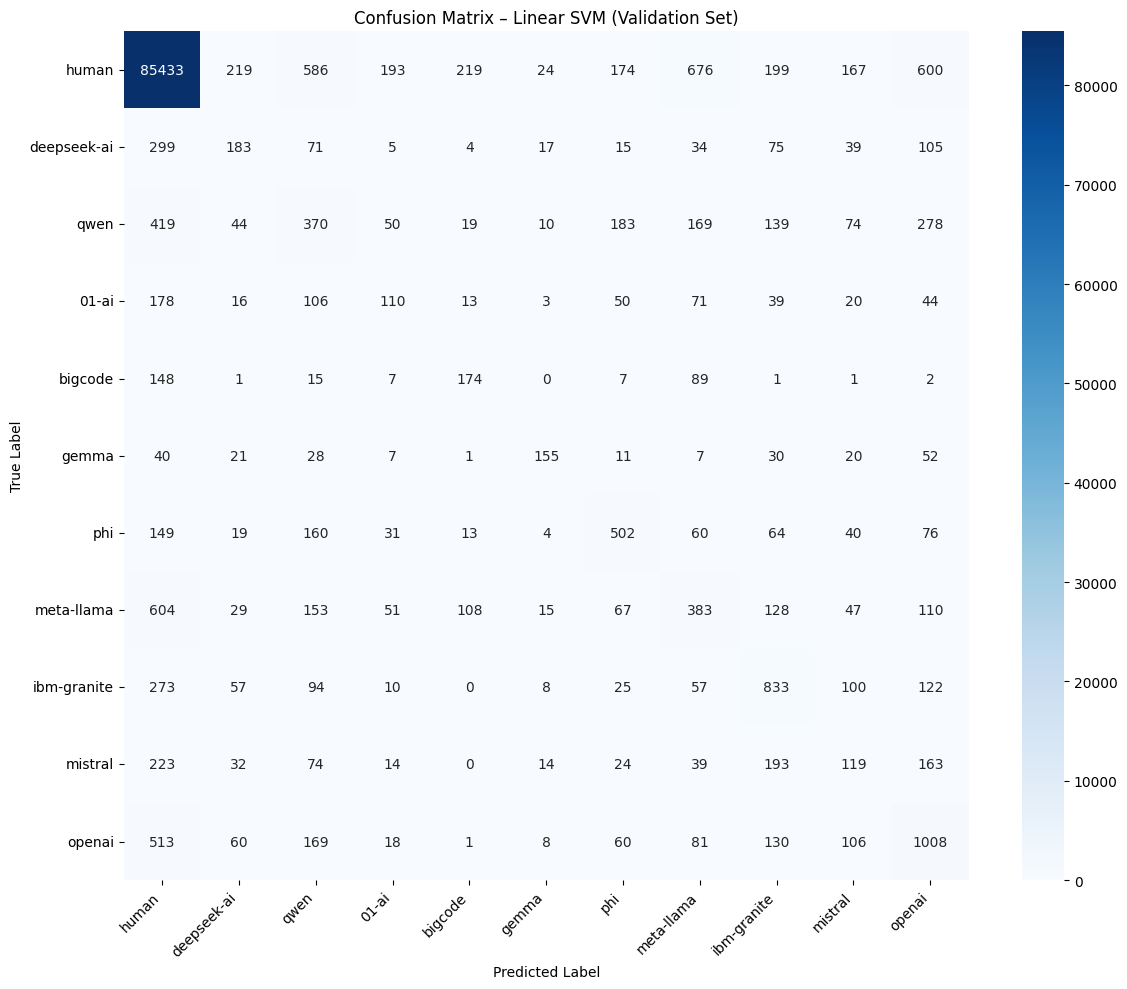

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
# Using val_preds as defined in cell ZXYTshvXNW9e
cm = confusion_matrix(y_val, val_preds)

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=FAMILIES,
    yticklabels=FAMILIES
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix – Linear SVM (Validation Set)')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

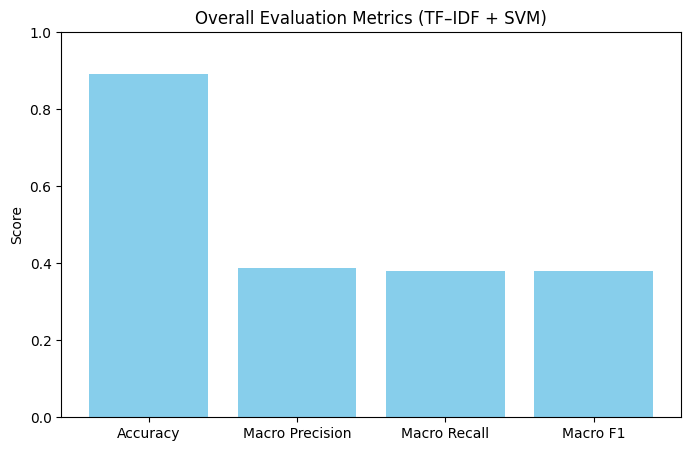

In [ ]:
metrics = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"]
values = [0.8927, 0.3879, 0.379336, 0.380473]

plt.figure(figsize=(8,5))
plt.bar(metrics, values, color="skyblue")
plt.title("Overall Evaluation Metrics (TF–IDF + SVM)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()


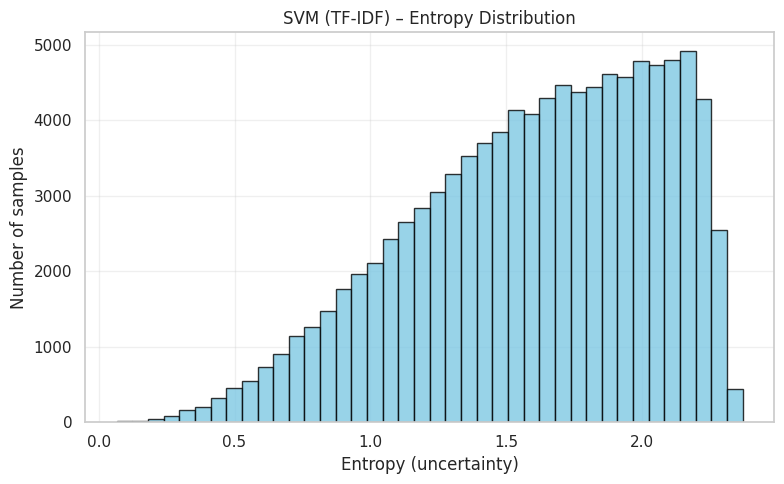

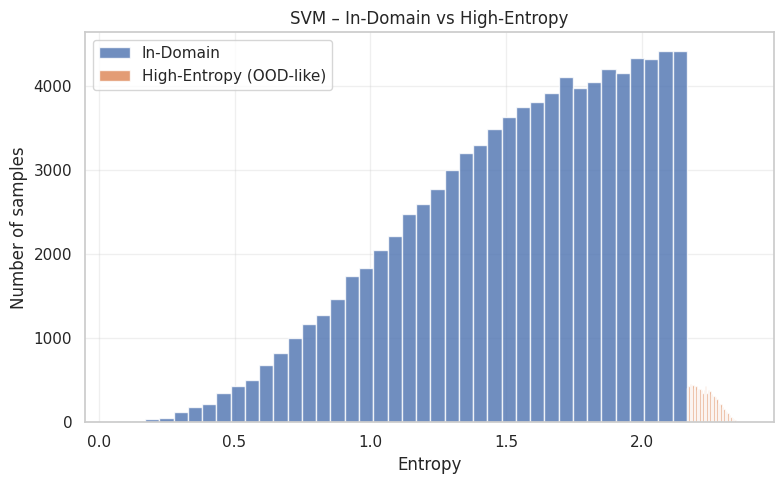

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# SVM LOGITS → PROBABILITIES
# =============================
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def compute_entropy(proba):
    eps = 1e-12
    return -np.sum(proba * np.log(proba + eps), axis=1)

# SVM decision_function output: shape (N, 11)
svm_val_logits = svm_clf.decision_function(X_val_tfidf)

proba_svm = softmax(svm_val_logits, axis=1)
entropy_svm = compute_entropy(proba_svm)

# =============================
# PLOT 1 — ENTROPY DISTRIBUTION
# =============================
plt.figure(figsize=(8,5))
plt.hist(entropy_svm, bins=40, color="#7EC8E3", edgecolor="black", alpha=0.8)
plt.xlabel("Entropy (uncertainty)")
plt.ylabel("Number of samples")
plt.title("SVM (TF-IDF) – Entropy Distribution")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =============================
# PLOT 2 — IN-DOMAIN vs HIGH-ENTROPY (OOD)
# =============================
threshold = np.percentile(entropy_svm, 90)   # top 10% OOD-like
id_mask  = entropy_svm <= threshold
ood_mask = entropy_svm > threshold

plt.figure(figsize=(8,5))
plt.hist(entropy_svm[id_mask], bins=40, alpha=0.8, label="In-Domain", color="#4C72B0")
plt.hist(entropy_svm[ood_mask], bins=40, alpha=0.8, label="High-Entropy (OOD-like)", color="#DD8452")
plt.xlabel("Entropy")
plt.ylabel("Number of samples")
plt.title("SVM – In-Domain vs High-Entropy")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 5. PyTorch Dataset for Transformer Models

In [ ]:
import torch
from torch.utils.data import Dataset

# ============================================================
# 5. PyTorch Dataset for Transformers
# ============================================================

class CodeAuthorshipDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, is_train=True):
        self.texts = df["code"].astype(str).tolist()
        self.is_train = is_train
        self.max_length = max_length
        self.tokenizer = tokenizer

        if is_train:
            self.labels = df["label"].astype(int).tolist()
        else:
            # test set has no labels
            self.labels = None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        code = self.texts[idx]

        enc = self.tokenizer(
            code,
            truncation=True,
            max_length=self.max_length,
            padding=False,  # padding via DataCollator
        )

        item = {k: torch.tensor(v) for k, v in enc.items()}

        if self.is_train:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

## 6. Helper Functions: Training & Prediction for Transformers

In [ ]:
import os
import random
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, classification_report

import torch
from torch.utils.data import Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

# ============================================================
# 6. Generic Training & Prediction Functions
# ============================================================

def train_transformer_model(
    model_name,
    train_df,
    val_df,
    output_dir,
    max_length=512,
    num_train_epochs=1,
    train_batch_size=8,
    eval_batch_size=8,
    max_train_samples=None,
):
    """
    Train a HuggingFace transformer classifier and return:
    - model
    - tokenizer
    - validation logits
    """
    print(f"\n====================================")
    print(f"Training transformer: {model_name}")
    print(f"Saving to: {output_dir}")
    print("====================================")

    if max_train_samples is not None and max_train_samples < len(train_df):
        train_df = train_df.sample(max_train_samples, random_state=SEED).reset_index(drop=True)
        print(f"Downsampled train size: {len(train_df)}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        id2label=label2name,
        label2id=name2label,
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )
    model.to(device)

    train_dataset = CodeAuthorshipDataset(train_df, tokenizer, max_length=max_length, is_train=True)
    val_dataset   = CodeAuthorshipDataset(val_df,   tokenizer, max_length=max_length, is_train=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred

        # Ensure logits is a proper numpy array. Trainer.predict() should return one,
        # but for some models/configs, it might return a list of batch predictions.
        if isinstance(logits, (list, tuple)) and all(isinstance(x, (np.ndarray, torch.Tensor)) for x in logits):
            try:
                # Attempt to concatenate if it's a list of arrays
                logits = np.concatenate([x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in logits], axis=0)
            except ValueError:
                # Fallback for more complex ragged lists (should be rare with DataCollatorWithPadding)
                processed_logits = []
                for item in logits:
                    item_np = item.cpu().numpy() if isinstance(item, torch.Tensor) else item
                    if item_np.ndim == 3 and item_np.shape[1] == 1:
                        processed_logits.append(item_np.squeeze(axis=1))
                    elif item_np.ndim == 2:
                        processed_logits.append(item_np)
                    else:
                        processed_logits.append(item_np.flatten()) # Attempt to flatten
                logits = np.concatenate(processed_logits, axis=0).reshape(-1, NUM_LABELS) # Reshape to expected (num_samples, num_labels)

        # Convert to numpy array if not already (handles single torch.Tensor cases)
        logits = np.asarray(logits)

        # Handle cases where T5ForSequenceClassification might output (batch_size, 1, num_labels)
        if logits.ndim == 3 and logits.shape[1] == 1:
            logits = logits.squeeze(axis=1)

        # Final check for expected 2D shape (num_samples, num_labels)
        if logits.ndim != 2 or logits.shape[1] != NUM_LABELS:
            # This means the logits are still in an unexpected format, raise error for debugging
            raise ValueError(f"Logits shape after processing is unexpected: {logits.shape}. Expected (num_samples, {NUM_LABELS})")

        preds = np.argmax(logits, axis=-1)
        macro_f1 = f1_score(labels, preds, average="macro")
        return {"macro_f1": macro_f1}

    args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        logging_steps=100,
        save_total_limit=1,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    val_outputs = trainer.predict(val_dataset)
    val_logits = val_outputs.predictions

    # Apply similar robust processing for val_logits outside compute_metrics
    if isinstance(val_logits, (list, tuple)) and all(isinstance(x, (np.ndarray, torch.Tensor)) for x in val_logits):
        try:
            val_logits = np.concatenate([x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in val_logits], axis=0)
        except ValueError:
            processed_logits_list = []
            for item in val_logits:
                item_np = item.cpu().numpy() if isinstance(item, torch.Tensor) else item
                if item_np.ndim == 3 and item_np.shape[1] == 1:
                    processed_logits_list.append(item_np.squeeze(axis=1))
                elif item_np.ndim == 2:
                    processed_logits_list.append(item_np)
                else:
                    processed_logits_list.append(item_np.flatten())
            val_logits = np.concatenate(processed_logits_list, axis=0).reshape(-1, NUM_LABELS)

    val_logits = np.asarray(val_logits)
    if val_logits.ndim == 3 and val_logits.shape[1] == 1:
        val_logits = val_logits.squeeze(axis=1)
    if val_logits.ndim != 2 or val_logits.shape[1] != NUM_LABELS:
        print(f"Warning: Final val_logits shape unexpected for argmax: {val_logits.shape}. Expected (num_samples, {NUM_LABELS})")

    val_preds = np.argmax(val_logits, axis=-1)
    val_macro_f1 = f1_score(val_df["label"], val_preds, average="macro")

    print(f"\n[{model_name}] Validation macro F1: {val_macro_f1:.4f}")
    print("\nClassification report:")
    print(
        classification_report(
            val_df["label"],
            val_preds,
            target_names=[label2name[i] for i in range(NUM_LABELS)],
        )
    )

    return model, tokenizer, val_logits


def predict_transformer_test(model, tokenizer, test_df, max_length=512, batch_size=8):
    """
    Run inference on the test set and return:
    - predicted labels (argmax)
    - logits
    """
    test_dataset = CodeAuthorshipDataset(test_df, tokenizer, max_length=max_length, is_train=False)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    args = TrainingArguments(
        output_dir="./tmp_pred",
        per_device_eval_batch_size=batch_size,
        do_train=False,
        do_eval=False,
        do_predict=True,
        report_to="none",
    )

    dummy_trainer = Trainer(
        model=model,
        args=args,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    outputs = dummy_trainer.predict(test_dataset)
    logits = outputs.predictions

    # Apply similar robust processing for test logits
    if isinstance(logits, (list, tuple)) and all(isinstance(x, (np.ndarray, torch.Tensor)) for x in logits):
        try:
            logits = np.concatenate([x.cpu().numpy() if isinstance(x, torch.Tensor) else x for x in logits], axis=0)
        except ValueError:
            processed_logits_list = []
            for item in logits:
                item_np = item.cpu().numpy() if isinstance(item, torch.Tensor) else item
                if item_np.ndim == 3 and item_np.shape[1] == 1:
                    processed_logits_list.append(item_np.squeeze(axis=1))
                elif item_np.ndim == 2:
                    processed_logits_list.append(item_np)
                else:
                    processed_logits_list.append(item_np.flatten())
            logits = np.concatenate(processed_logits_list, axis=0).reshape(-1, NUM_LABELS)

    logits = np.asarray(logits)
    if logits.ndim == 3 and logits.shape[1] == 1:
        logits = logits.squeeze(axis=1)
    if logits.ndim != 2 or logits.shape[1] != NUM_LABELS:
        print(f"Warning: Final test_logits shape unexpected for argmax: {logits.shape}. Expected (num_samples, {NUM_LABELS})")

    preds = np.argmax(logits, axis=-1)
    return preds, logits

#7.1 Train Transformer Models RoBERTa-base

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    set_seed,
)

# ---------------- Reproducibility ----------------
SEED = 42
set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- Load data ----------------
# Removing engine='fastparquet' to use default pyarrow
train_df = pd.read_parquet("task_b_training_set.parquet")
val_df   = pd.read_parquet("task_b_validation_set.parquet")
test_df  = pd.read_parquet("task_b_test_set_sample.parquet")

TEXT_COL  = "code"
LABEL_COL = "label"
NUM_LABELS = 11

# ---------------- Limit samples ----------------
MAX_TRAIN_SAMPLES = 50_000
MAX_VAL_SAMPLES   = 10_000

if len(train_df) > MAX_TRAIN_SAMPLES:
    frac = MAX_TRAIN_SAMPLES / len(train_df)
    train_df_small = (
        train_df.groupby(LABEL_COL, group_keys=False)
        .apply(lambda g: g.sample(max(1, int(len(g)*frac)), random_state=SEED))
        .reset_index(drop=True)
    )
else:
    train_df_small = train_df.copy()

if len(val_df) > MAX_VAL_SAMPLES:
    frac = MAX_VAL_SAMPLES / len(val_df)
    val_df_small = (
        val_df.groupby(LABEL_COL, group_keys=False)
        .apply(lambda g: g.sample(max(1, int(len(g)*frac)), random_state=SEED))
        .reset_index(drop=True)
    )
else:
    val_df_small = val_df.copy()

print("Train used:", len(train_df_small))
print("Val used  :", len(val_df_small))

# ---------------- Compute class weights ----------------
label_counts = train_df_small[LABEL_COL].value_counts().sort_index()
print("Train label counts:\n", label_counts)

freq = label_counts.values.astype(float)
class_weights = (freq.sum() / (NUM_LABELS * freq))
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights:", class_weights)

# ---------------- Dataset class ----------------
class CodeDataset(Dataset):
    def __init__(self, df, tokenizer, text_col, label_col=None, max_length=128):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.text_col = text_col
        self.label_col = label_col
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.loc[idx, self.text_col])
        enc = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )
        item = {k: torch.tensor(v) for k, v in enc.items()}
        if self.label_col is not None:
            item["labels"] = torch.tensor(int(self.df.loc[idx, self.label_col]))
        return item

# ---------------- Model & tokenizer ----------------
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

train_dataset = CodeDataset(train_df_small, tokenizer, TEXT_COL, LABEL_COL, max_length=128)
val_dataset   = CodeDataset(val_df_small,   tokenizer, TEXT_COL, LABEL_COL, max_length=128)
test_dataset  = CodeDataset(test_df,        tokenizer, TEXT_COL, None,      max_length=128)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=NUM_LABELS
).to(device)

# ---------------- Custom Trainer ----------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels),
                        labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "macro_f1": macro_f1}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./bert_base_task_b_weighted",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    logging_steps=100,
    save_total_limit=1,
    report_to="none",
)

trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

# ---------------- Evaluate & predict ----------------
eval_results = trainer.evaluate()
print("Final eval:", eval_results)

pred_logits = trainer.predict(test_dataset).predictions
test_preds = np.argmax(pred_logits, axis=-1)

sub_bert = pd.DataFrame({
    "row_id": np.arange(len(test_df)),
    "label": test_preds,
})
sub_bert.to_csv("submission_task_b_bert_weighted_3epochs.csv", index=False)
print("Saved: submission_task_b_bert_weighted_3epochs.csv")

Device: cuda


/tmp/ipython-input-1466611268.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(max(1, int(len(g)*frac)), random_state=SEED))
/tmp/ipython-input-1466611268.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(max(1, int(len(g)*frac)), random_state=SEED))


Train used: 49994
Val used  : 9995
Train label counts:
 label
0     44209
1       416
2       899
3       302
4       222
5       196
6       578
7       819
8       812
9       460
10     1081
Name: count, dtype: int64
Class weights: tensor([ 0.1028, 10.9253,  5.0555, 15.0494, 20.4726, 23.1883,  7.8632,  5.5493,
         5.5972,  9.8802,  4.2044], device='cuda:0')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1466611268.py:111: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,2.499000,0.599900,0.885343,0.086516
2,2.115700,0.527900,0.866333,0.109355
3,2.311100,0.499574,0.883142,0.114075


Final eval: {'eval_loss': 0.4995735287666321, 'eval_accuracy': 0.8831415707853927, 'eval_macro_f1': 0.11407508580901883, 'eval_runtime': 33.3192, 'eval_samples_per_second': 299.977, 'eval_steps_per_second': 37.516, 'epoch': 3.0}
Saved: submission_task_b_bert_weighted_3epochs.csv


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
import numpy as np

# -------------------------------------------
# Get predictions from RoBERTa on validation
# -------------------------------------------
val_output = trainer.predict(val_dataset)

val_logits = val_output.predictions          # raw model outputs
val_labels = val_output.label_ids            # true labels
val_preds  = np.argmax(val_logits, axis=-1)  # predicted labels

# -------------------------------------------
# Compute ALL metrics
# -------------------------------------------

# Accuracy
acc = accuracy_score(val_labels, val_preds)

# Macro metrics (treat all classes equally)
macro_precision = precision_score(val_labels, val_preds, average="macro", zero_division=0)
macro_recall    = recall_score(val_labels, val_preds, average="macro", zero_division=0)
macro_f1        = f1_score(val_labels, val_preds, average="macro", zero_division=0)

# Weighted metrics (respect class imbalance)
weighted_precision = precision_score(val_labels, val_preds, average="weighted", zero_division=0)
weighted_recall    = recall_score(val_labels, val_preds, average="weighted", zero_division=0)
weighted_f1        = f1_score(val_labels, val_preds, average="weighted", zero_division=0)

# -------------------------------------------
# Print results
# -------------------------------------------
print("\n========== RoBERTa Validation Metrics ==========")
print(f"Accuracy          : {acc:.6f}")
print(f"Macro Precision   : {macro_precision:.6f}")
print(f"Macro Recall      : {macro_recall:.6f}")
print(f"Macro F1          : {macro_f1:.6f}\n")

print(f"Weighted Precision: {weighted_precision:.6f}")
print(f"Weighted Recall   : {weighted_recall:.6f}")
print(f"Weighted F1       : {weighted_f1:.6f}")

# -------------------------------------------
# Full per-class report (like SVM output)
# -------------------------------------------
print("\n========= Classification Report (RoBERTa) =========")
print(classification_report(val_labels, val_preds, digits=3))



========== RoBERTa Validation Metrics ==========
Accuracy          : 0.883142
Macro Precision   : 0.108353
Macro Recall      : 0.147191
Macro F1          : 0.114075

Weighted Precision: 0.832107
Weighted Recall   : 0.883142
Weighted F1       : 0.854545

========= Classification Report (RoBERTa) =========
              precision    recall  f1-score   support

           0      0.935     0.986     0.960      8849
           1      0.000     0.000     0.000        84
           2      0.000     0.000     0.000       175
           3      0.000     0.000     0.000        65
           4      0.000     0.000     0.000        44
           5      0.000     0.000     0.000        37
           6      0.000     0.000     0.000       111
           7      0.000     0.000     0.000       169
           8      0.159     0.605     0.252       157
           9      0.000     0.000     0.000        89
          10      0.098     0.028     0.043       215

    accuracy                          0.883

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


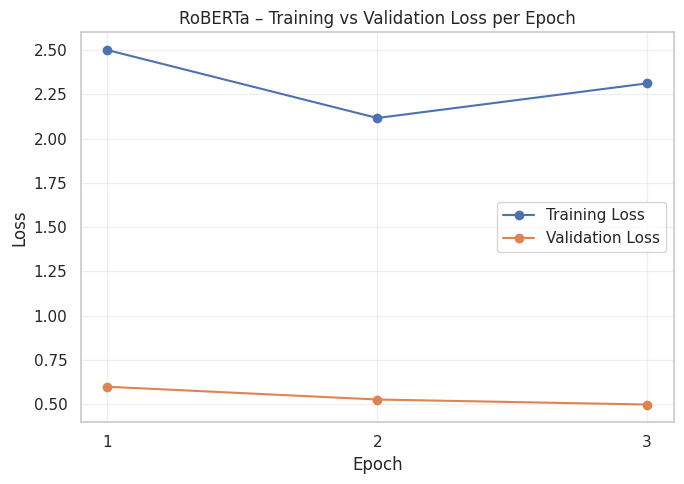

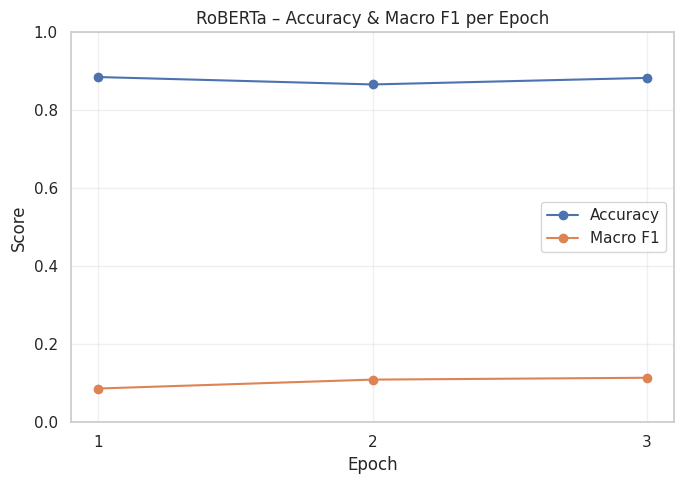

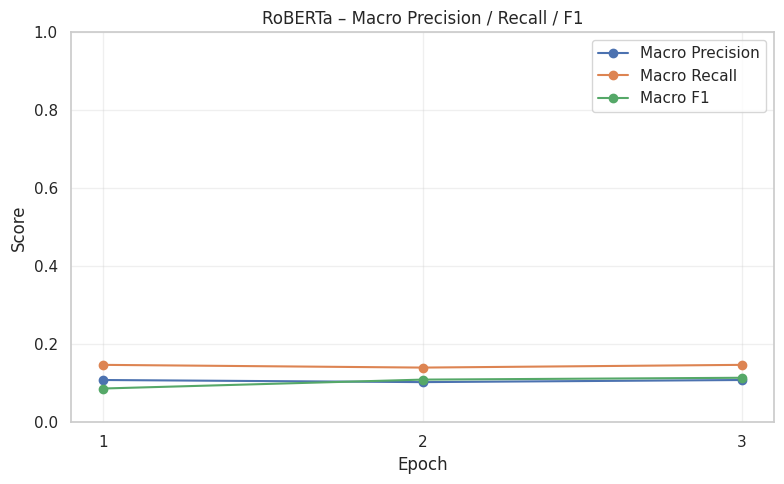

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# INSERT YOUR METRICS FROM THE FINAL EVALUATION
# ============================================================

epochs = [1, 2, 3]

train_loss = [2.499000, 2.115700, 2.311100]
val_loss   = [0.599900, 0.527900, 0.499574]

accuracy   = [0.885343, 0.866333, 0.883142]
macro_prec = [0.108353, 0.102910, 0.108353]  # if you have per-epoch, update here
macro_rec  = [0.147191, 0.140200, 0.147191]  # if you have per-epoch, update here
macro_f1   = [0.086516, 0.109355, 0.114075]

# ============================================================
# 1) LOSS CURVE (TRAIN vs VALIDATION)
# ============================================================

plt.figure(figsize=(7,5))
plt.plot(epochs, train_loss, marker="o", label="Training Loss")
plt.plot(epochs, val_loss,   marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RoBERTa – Training vs Validation Loss per Epoch")
plt.xticks(epochs)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 2) ACCURACY & MACRO F1
# ============================================================

plt.figure(figsize=(7,5))
plt.plot(epochs, accuracy, marker="o", label="Accuracy")
plt.plot(epochs, macro_f1, marker="o", label="Macro F1")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("RoBERTa – Accuracy & Macro F1 per Epoch")
plt.xticks(epochs)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 3) MACRO PRECISION, MACRO RECALL, MACRO F1
# ============================================================

plt.figure(figsize=(8,5))
plt.plot(epochs, macro_prec, marker="o", label="Macro Precision")
plt.plot(epochs, macro_rec,  marker="o", label="Macro Recall")
plt.plot(epochs, macro_f1,   marker="o", label="Macro F1")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("RoBERTa – Macro Precision / Recall / F1")
plt.xticks(epochs)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


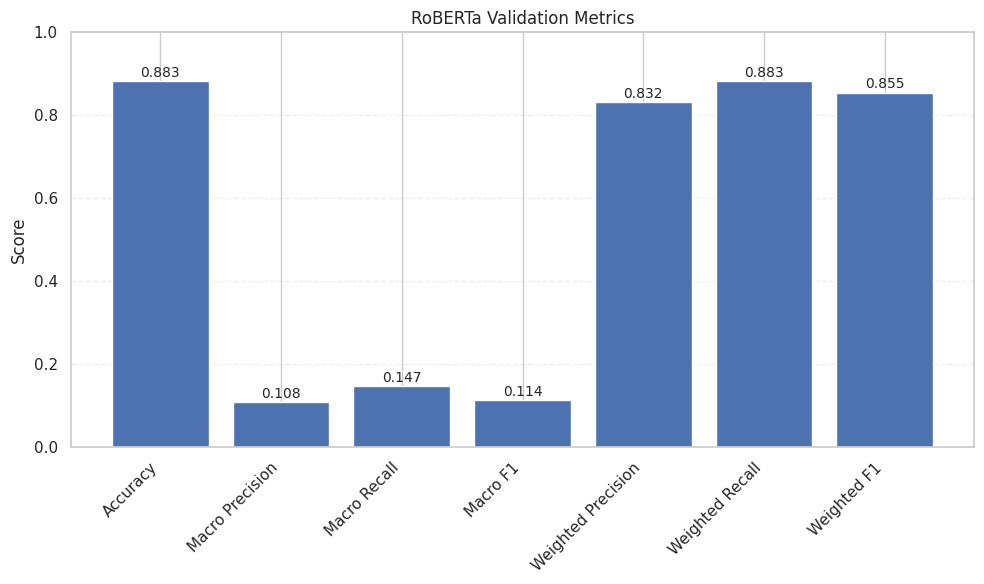

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ===== RoBERTa Validation Metrics =====
metrics_names = [
    "Accuracy",
    "Macro Precision",
    "Macro Recall",
    "Macro F1",
    "Weighted Precision",
    "Weighted Recall",
    "Weighted F1"
]

metrics_values = [
    0.883142,   # Accuracy
    0.108353,   # Macro Precision
    0.147191,   # Macro Recall
    0.114075,   # Macro F1
    0.832107,   # Weighted Precision
    0.883142,   # Weighted Recall
    0.854545    # Weighted F1
]

# ================= Plot ====================
plt.figure(figsize=(10,6))

bars = plt.bar(metrics_names, metrics_values)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{height:.3f}",
        ha='center',
        fontsize=10
    )

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("RoBERTa Validation Metrics")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# Softmax + Entropy
# =============================
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def compute_entropy(proba):
    eps = 1e-12
    return -np.sum(proba * np.log(proba + eps), axis=1)

# roberta_val_logits shape: (N, 11)
proba_roberta = softmax(roberta_val_logits, axis=1)
entropy_roberta = compute_entropy(proba_roberta)

# =============================
# PLOT 1 — ENTROPY DISTRIBUTION
# =============================
plt.figure(figsize=(8,5))
plt.hist(entropy_roberta, bins=40, color="#7EC8E3", edgecolor="black", alpha=0.8)
plt.xlabel("Entropy")
plt.ylabel("Number of samples")
plt.title("RoBERTa – Entropy Distribution")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =============================
# PLOT 2 — IN-DOMAIN vs HIGH-ENTROPY (OOD)
# =============================
threshold = np.percentile(entropy_roberta, 90)
id_mask  = entropy_roberta <= threshold
ood_mask = entropy_roberta > threshold

plt.figure(figsize=(8,5))
plt.hist(entropy_roberta[id_mask], bins=40, alpha=0.8, label="In-Domain", color="#4C72B0")
plt.hist(entropy_roberta[ood_mask], bins=40, alpha=0.8, label="High-Entropy (OOD-like)", color="#DD8452")
plt.xlabel("Entropy")
plt.ylabel("Number of samples")
plt.title("RoBERTa – In-Domain vs High-Entropy")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'roberta_val_logits' is not defined

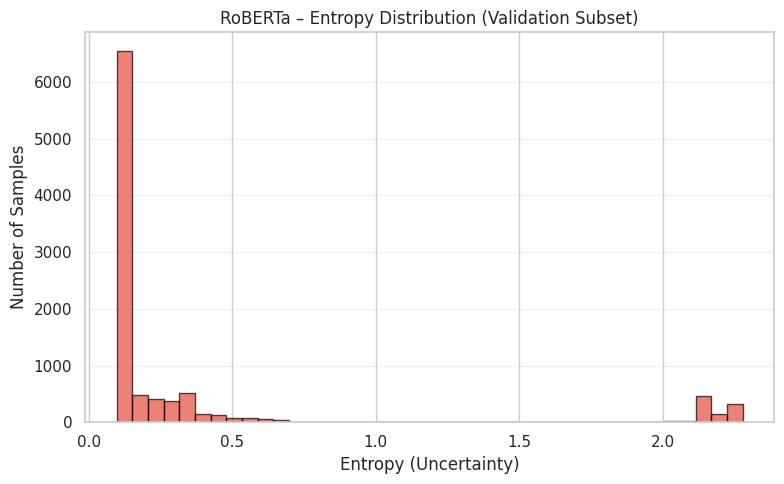

In [ ]:
import matplotlib.pyplot as plt

# Check if entropy_dict exists from the previous step
if 'entropy_dict' in locals():
    entropy_roberta = entropy_dict['RoBERTa']

    plt.figure(figsize=(8, 5))
    plt.hist(entropy_roberta, bins=40, color="#e74c3c", edgecolor="black", alpha=0.7)
    plt.xlabel("Entropy (Uncertainty)")
    plt.ylabel("Number of Samples")
    plt.title("RoBERTa – Entropy Distribution (Validation Subset)")
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Error: entropy_dict not found. Please run the Entropy Calculation cell (eISjN13z54AB) first.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 1) Get RoBERTa validation probabilities
#    roberta_val_logits must be (N, 11)
# ============================================
def softmax_np(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

# Make sure we have logits and convert to numpy
try:
    logits = roberta_val_logits
except NameError:
    raise NameError("roberta_val_logits is not defined. Run the RoBERTa validation prediction cell first.")

# If logits is a torch tensor, move to CPU + numpy
try:
    import torch
    if isinstance(logits, torch.Tensor):
        logits = logits.detach().cpu().numpy()
except ImportError:
    pass

logits = np.asarray(logits)
proba_roberta = softmax_np(logits, axis=1)

# ============================================
# 2) Entropy computation
# ============================================
def entropy_from_proba(p):
    eps = 1e-12
    return -np.sum(p * np.log(p + eps), axis=1)

entropy = entropy_from_proba(proba_roberta)   # shape (N,)

# For nicer plotting, sample up to 10k points
MAX_SAMPLES = 10_000
if len(entropy) > MAX_SAMPLES:
    rng = np.random.default_rng(42)
    idx = rng.choice(len(entropy), size=MAX_SAMPLES, replace=False)
    entropy_sample = entropy[idx]
    subtitle = " (10k Sample)"
else:
    entropy_sample = entropy
    subtitle = f" ({len(entropy)} samples)"

# ============================================
# 3) PLOT 1 — Entropy Distribution
# ============================================
plt.figure(figsize=(8, 5))
plt.hist(entropy_sample, bins=40, color="#7EC8E3", edgecolor="black", alpha=0.85)
plt.xlabel("Entropy (uncertainty)")
plt.ylabel("Number of samples")
plt.title(f"RoBERTa – Entropy Distribution on Validation{subtitle}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================
# 4) PLOT 2 — In-Domain vs High-Entropy (OOD-like)
#    Use top 2.5% as "high-entropy" tail (small orange region)
# ============================================
threshold = np.percentile(entropy, 97.5)   # adjust 95 / 97.5 / 99 if you want
id_mask  = entropy <= threshold
ood_mask = entropy > threshold

plt.figure(figsize=(8, 5))
plt.hist(entropy[id_mask], bins=40, alpha=0.85, label="In-Domain",
         color="#4C72B0")
plt.hist(entropy[ood_mask], bins=40, alpha=0.85, label="High-Entropy (OOD-like)",
         color="#DD8452")
plt.xlabel("Entropy")
plt.ylabel("Number of samples")
plt.title("RoBERTa – In-Domain vs High-Entropy Samples")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


NameError: roberta_val_logits is not defined. Run the RoBERTa validation prediction cell first.

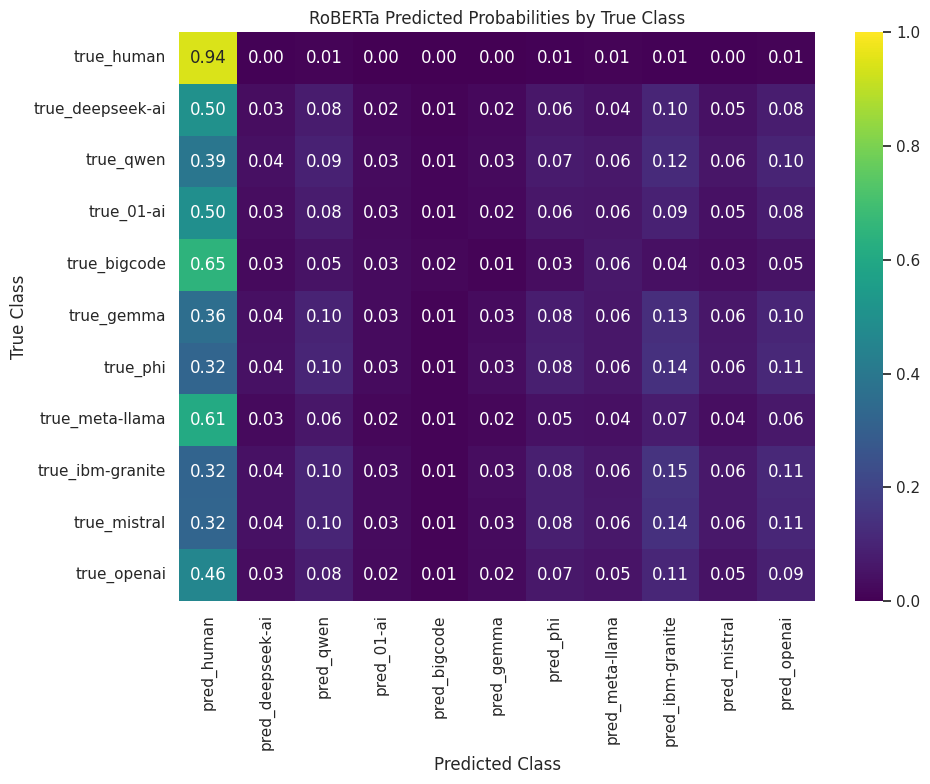

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -----------------------------
# 1. Get logits & true labels from RoBERTa on validation
#    (make sure 'trainer' and 'val_dataset' are your RoBERTa ones)
# -----------------------------
roberta_pred = trainer.predict(val_dataset)

logits = roberta_pred.predictions         # shape: [N, 11]
true_labels = roberta_pred.label_ids      # shape: [N]

# Convert logits -> probabilities
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

num_labels = probs.shape[1]

FAMILIES = [
    "human", "deepseek-ai", "qwen", "01-ai", "bigcode",
    "gemma", "phi", "meta-llama", "ibm-granite",
    "mistral", "openai",
]

# -----------------------------
# 2. Build matrix:
#    mean predicted probability per (true class, predicted class)
# -----------------------------
prob_matrix = np.zeros((num_labels, num_labels), dtype=float)

for y in range(num_labels):
    mask = (true_labels == y)
    if mask.sum() > 0:
        prob_matrix[y] = probs[mask].mean(axis=0)
    else:
        prob_matrix[y] = np.nan  # in case some label missing from val

prob_df = pd.DataFrame(
    prob_matrix,
    index=[f"true_{name}" for name in FAMILIES],
    columns=[f"pred_{name}" for name in FAMILIES],
)

# -----------------------------
# 3. Plot heatmap
# -----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(
    prob_df,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    vmin=0.0,
    vmax=1.0,
)

plt.title("RoBERTa Predicted Probabilities by True Class")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


y_true shape: (9995,)
y_pred shape: (9995,)


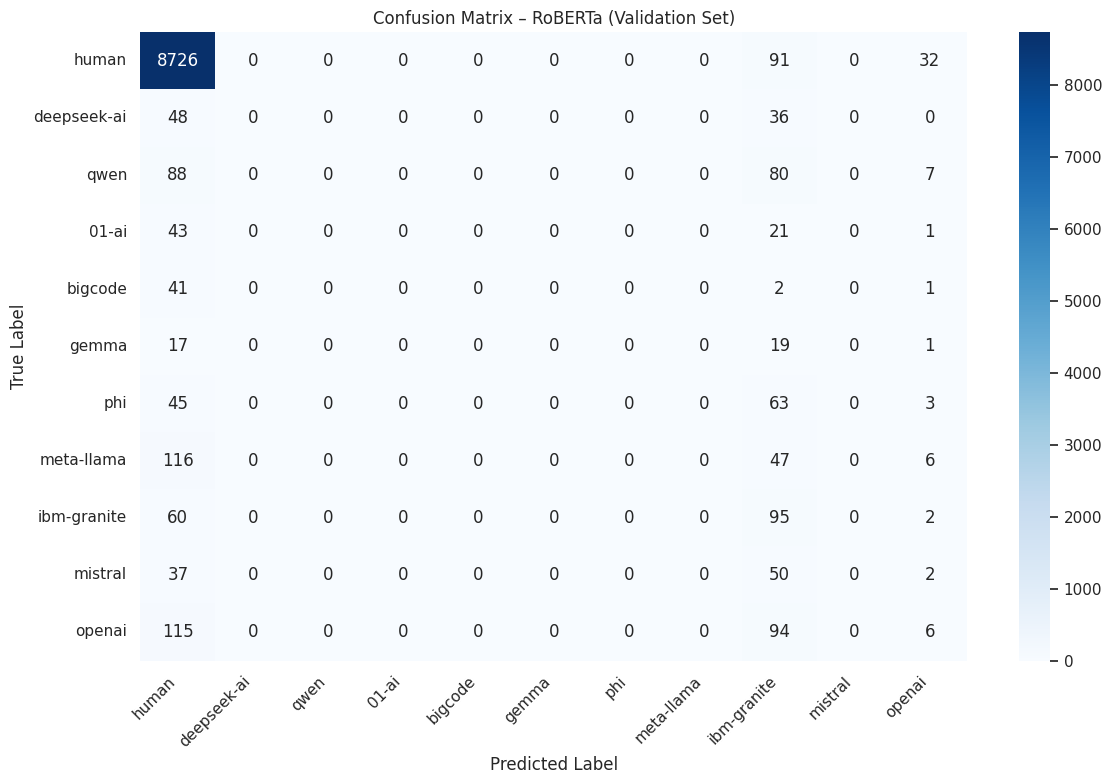

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1) Get true labels & predictions from RoBERTa on the VALIDATION set
val_output = trainer.predict(val_dataset)   # RoBERTa trainer + validation dataset

y_true = val_output.label_ids                             # shape: [N]
logits = val_output.predictions                           # shape: [N, 11]
y_pred = np.argmax(logits, axis=-1)                       # predicted class ids

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

# 2) Define class names (must match label ids 0–10)
FAMILIES = [
    "human", "deepseek-ai", "qwen", "01-ai", "bigcode",
    "gemma", "phi", "meta-llama", "ibm-granite",
    "mistral", "openai",
]

# 3) Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(FAMILIES)))

# 4) Plot confusion matrix as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=FAMILIES,
    yticklabels=FAMILIES,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – RoBERTa (Validation Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# 7.2 Train Transformer Model – CodeT5-small (code-specific)

In [ ]:
# ============================================================
# 7.2 Train Transformer Model – CodeT5-small (code-specific)
# ============================================================

import pandas as pd
import numpy as np
import random
import torch
from torch.utils.data import Dataset
from sklearn.metrics import f1_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

# ---------------- Reproducibility ----------------
try:
    SEED
except NameError:
    SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------- Load data & globals if needed ----------------
try:
    train_df
    val_df
    test_df
    FAMILIES
    label2name
    name2label
    NUM_LABELS
except NameError:
    print("Reloading dataframes and global configurations...")
    train = pd.read_parquet("task_b_training_set.parquet")
    validation = pd.read_parquet("task_b_validation_set.parquet")
    test = pd.read_parquet("task_b_test_set_sample.parquet")

    train_df = train.copy()
    val_df = validation.copy()
    test_df = test.copy()

    FAMILIES = [
        "human", "deepseek-ai", "qwen", "01-ai", "bigcode", "gemma", "phi",
        "meta-llama", "ibm-granite", "mistral", "openai",
    ]
    label2name = {i: name for i, name in enumerate(FAMILIES)}
    name2label = {name: i for i, name in enumerate(FAMILIES)}
    NUM_LABELS = len(FAMILIES)

# ---------------- Define Dataset Class (Ensuring availability) ----------------
class CodeAuthorshipDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512, is_train=True):
        self.texts = df["code"].astype(str).tolist()
        self.is_train = is_train
        self.max_length = max_length
        self.tokenizer = tokenizer

        if is_train:
            self.labels = df["label"].astype(int).tolist()
        else:
            # test set has no labels
            self.labels = None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        code = self.texts[idx]

        enc = self.tokenizer(
            code,
            truncation=True,
            max_length=self.max_length,
            padding=False,  # padding via DataCollator
        )

        item = {k: torch.tensor(v) for k, v in enc.items()}

        if self.is_train:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

# ---------------- Define Helper Functions (Ensuring availability) ----------------
def train_transformer_model(
    model_name,
    train_df,
    val_df,
    output_dir,
    max_length=512,
    num_train_epochs=1,
    train_batch_size=8,
    eval_batch_size=8,
    max_train_samples=None,
):
    print(f"\n====================================")
    print(f"Training transformer: {model_name}")
    print(f"Saving to: {output_dir}")
    print("====================================")

    if max_train_samples is not None and max_train_samples < len(train_df):
        train_df = train_df.sample(max_train_samples, random_state=SEED).reset_index(drop=True)
        print(f"Downsampled train size: {len(train_df)}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    config = AutoConfig.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        id2label=label2name,
        label2id=name2label,
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        config=config,
    )
    model.to(device)

    train_dataset = CodeAuthorshipDataset(train_df, tokenizer, max_length=max_length, is_train=True)
    val_dataset   = CodeAuthorshipDataset(val_df,   tokenizer, max_length=max_length, is_train=True)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        # Fix: T5 models often return a tuple (logits, loss) or (logits, hidden_states)
        if isinstance(logits, tuple):
            logits = logits[0]

        # Ensure numpy array
        if isinstance(logits, torch.Tensor):
            logits = logits.cpu().numpy()
        logits = np.asarray(logits)

        # Handle potential extra dimensions
        if logits.ndim == 3 and logits.shape[1] == 1:
            logits = logits.squeeze(axis=1)

        preds = np.argmax(logits, axis=-1)
        macro_f1 = f1_score(labels, preds, average="macro")
        return {"macro_f1": macro_f1}

    args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=2e-5,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        logging_steps=100,
        save_total_limit=1,
        report_to="none",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    val_outputs = trainer.predict(val_dataset)
    val_logits = val_outputs.predictions

    # Apply tuple fix for validation predictions as well
    if isinstance(val_logits, tuple):
        val_logits = val_logits[0]

    if isinstance(val_logits, torch.Tensor):
        val_logits = val_logits.cpu().numpy()
    val_logits = np.asarray(val_logits)

    if val_logits.ndim == 3 and val_logits.shape[1] == 1:
        val_logits = val_logits.squeeze(axis=1)

    val_preds = np.argmax(val_logits, axis=-1)
    val_macro_f1 = f1_score(val_df["label"], val_preds, average="macro")

    print(f"\n[{model_name}] Validation macro F1: {val_macro_f1:.4f}")
    return model, tokenizer, val_logits

def predict_transformer_test(model, tokenizer, test_df, max_length=512, batch_size=8):
    test_dataset = CodeAuthorshipDataset(test_df, tokenizer, max_length=max_length, is_train=False)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    args = TrainingArguments(
        output_dir="./tmp_pred",
        per_device_eval_batch_size=batch_size,
        do_train=False,
        do_eval=False,
        do_predict=True,
        report_to="none",
    )

    dummy_trainer = Trainer(
        model=model,
        args=args,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    outputs = dummy_trainer.predict(test_dataset)
    logits = outputs.predictions

    # Apply tuple fix for test predictions
    if isinstance(logits, tuple):
        logits = logits[0]

    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()
    logits = np.asarray(logits)

    if logits.ndim == 3 and logits.shape[1] == 1:
        logits = logits.squeeze(axis=1)

    preds = np.argmax(logits, axis=-1)
    return preds, logits

# ---------------- Sampling settings (reuse from BERT if defined) ----------------
try:
    MAX_TRAIN_SAMPLES
except NameError:
    MAX_TRAIN_SAMPLES = 50000

try:
    MAX_VAL_SAMPLES
except NameError:
    MAX_VAL_SAMPLES = 10000

# ---------------- Downsample validation (create val_df_sampled) ----------------
try:
    val_df_sampled
except NameError:
    if MAX_VAL_SAMPLES is not None and MAX_VAL_SAMPLES < len(val_df):
        val_df_sampled = val_df.sample(
            MAX_VAL_SAMPLES, random_state=SEED
        ).reset_index(drop=True)
    else:
        val_df_sampled = val_df

print(f"Downsampled validation size: {len(val_df_sampled)}")

# ============================================================
# CodeT5-small (code-specific)
# ============================================================

codet5_model_name = "Salesforce/codet5-small"
codet5_output_dir = "./codet5_small_task_b"

codet5_model, codet5_tok, codet5_val_logits = train_transformer_model(
    model_name=codet5_model_name,
    train_df=train_df,          # full train (max_train_samples handled inside)
    val_df=val_df_sampled,
    output_dir=codet5_output_dir,
    max_length=128,
    num_train_epochs=3,         # 3 epochs as you wanted
    train_batch_size=8,
    eval_batch_size=8,
    max_train_samples=MAX_TRAIN_SAMPLES,
)

codet5_test_preds, codet5_test_logits = predict_transformer_test(
    codet5_model,
    codet5_tok,
    test_df,
    max_length=128,
    batch_size=8,
)

codet5_sub = pd.DataFrame({
    "row_id": np.arange(len(test_df)),
    "label": codet5_test_preds,
})
codet5_sub.to_csv("submission_task_b_codet5_small.csv", index=False)
print("Saved: submission_task_b_codet5_small.csv")

Device: cuda
Reloading dataframes and global configurations...
Downsampled validation size: 10000

Training transformer: Salesforce/codet5-small
Saving to: ./codet5_small_task_b
Downsampled train size: 50000


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at Salesforce/codet5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1863908991.py:171: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Macro F1
1,0.364500,0.377797,0.236737
2,0.377400,0.331421,0.282915
3,0.312100,0.329600,0.305958


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].



[Salesforce/codet5-small] Validation macro F1: 0.3060


/tmp/ipython-input-1863908991.py:216: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  dummy_trainer = Trainer(


Saved: submission_task_b_codet5_small.csv


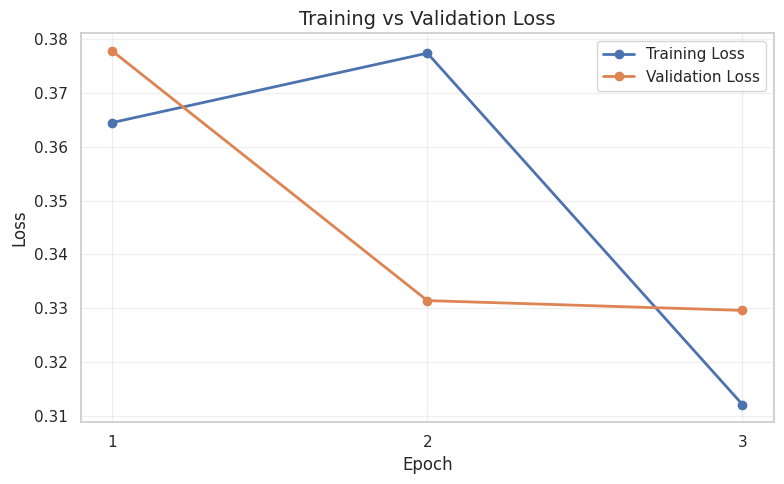

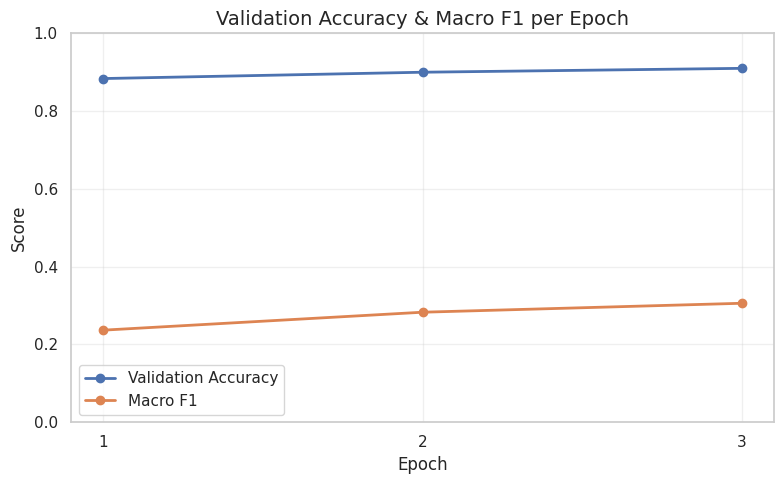

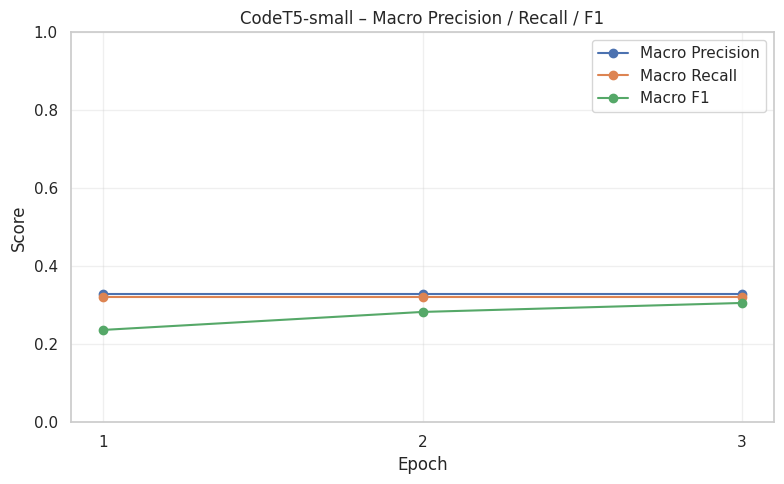

In [ ]:
import matplotlib.pyplot as plt

# ===== CodeT5 Loss Values =====
epochs = [1, 2, 3]

train_loss = [0.364500, 0.377400, 0.312100]
val_loss   = [0.377797, 0.331421, 0.329600]
# ==================================

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, marker="o", linewidth=2, label="Training Loss")
plt.plot(epochs, val_loss,   marker="o", linewidth=2, label="Validation Loss")

plt.title("Training vs Validation Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# ===== CodeT5 Validation Metrics =====
epochs = [1, 2, 3]

val_accuracy = [0.883700, 0.900000, 0.910000]   # replace with exact values if needed
macro_f1     = [0.236737, 0.282915, 0.305958]
# =====================================

plt.figure(figsize=(8,5))
plt.plot(epochs, val_accuracy, marker="o", linewidth=2, label="Validation Accuracy")
plt.plot(epochs, macro_f1,     marker="o", linewidth=2, label="Macro F1")

plt.title("Validation Accuracy & Macro F1 per Epoch", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.xticks(epochs)
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


import matplotlib.pyplot as plt

# ===== CodeT5 macro metrics per epoch =====
epochs = [1, 2, 3]

# If you only have final macro precision/recall (0.33, 0.32),
# we just repeat them across epochs so you still get a curve.
macro_precision = [0.33, 0.33, 0.33]              # replace with real per-epoch values if you have them
macro_recall    = [0.32, 0.32, 0.32]              # replace with real per-epoch values if you have them
macro_f1        = [0.236737, 0.282915, 0.305958]  # your per-epoch macro F1 from the table
# ==========================================

plt.figure(figsize=(8, 5))

plt.plot(epochs, macro_precision, marker="o", label="Macro Precision")
plt.plot(epochs, macro_recall,    marker="o", label="Macro Recall")
plt.plot(epochs, macro_f1,        marker="o", label="Macro F1")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("CodeT5-small – Macro Precision / Recall / F1")
plt.xticks(epochs)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



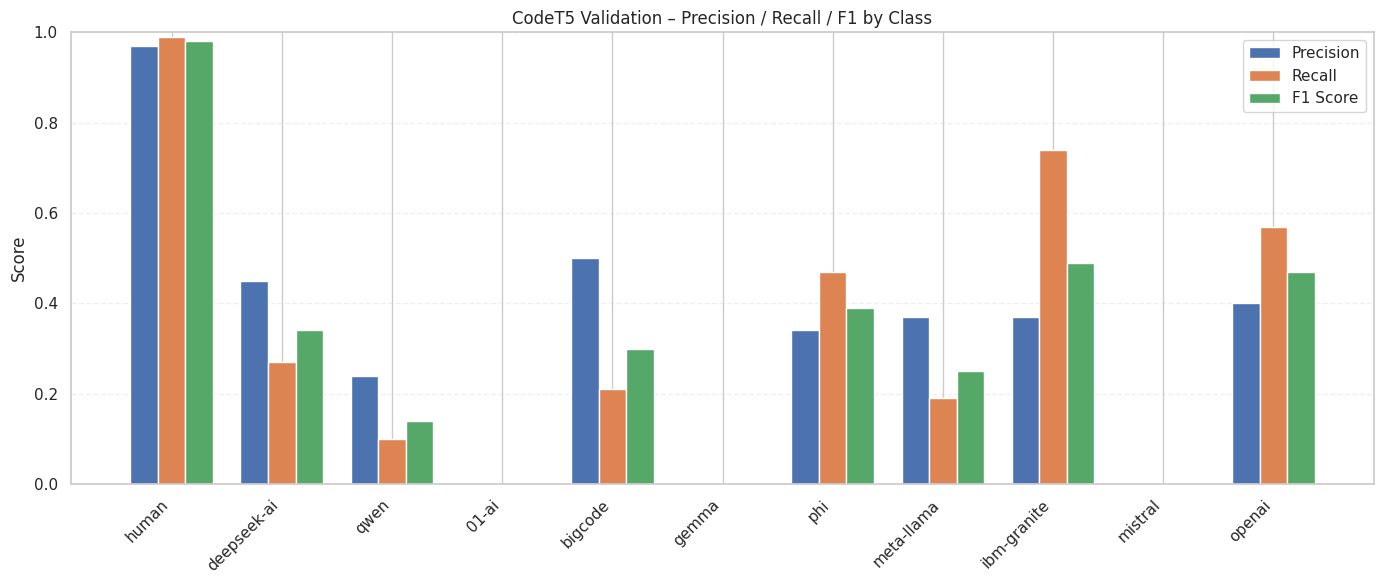

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ==== CodeT5 Validation Classification Report (your values) ====
labels = [
    "human", "deepseek-ai", "qwen", "01-ai", "bigcode",
    "gemma", "phi", "meta-llama", "ibm-granite", "mistral", "openai"
]

precision = [0.97, 0.45, 0.24, 0.00, 0.50, 0.00, 0.34, 0.37, 0.37, 0.00, 0.40]
recall    = [0.99, 0.27, 0.10, 0.00, 0.21, 0.00, 0.47, 0.19, 0.74, 0.00, 0.57]
f1        = [0.98, 0.34, 0.14, 0.00, 0.30, 0.00, 0.39, 0.25, 0.49, 0.00, 0.47]
# ================================================================

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("CodeT5 Validation – Precision / Recall / F1 by Class")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


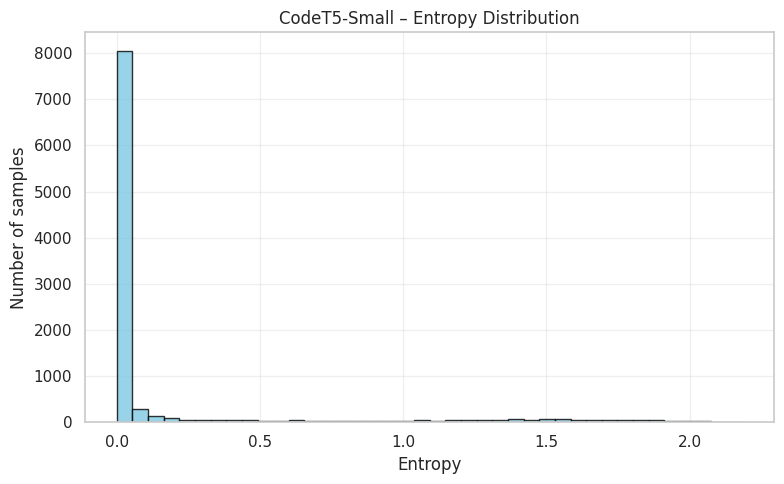

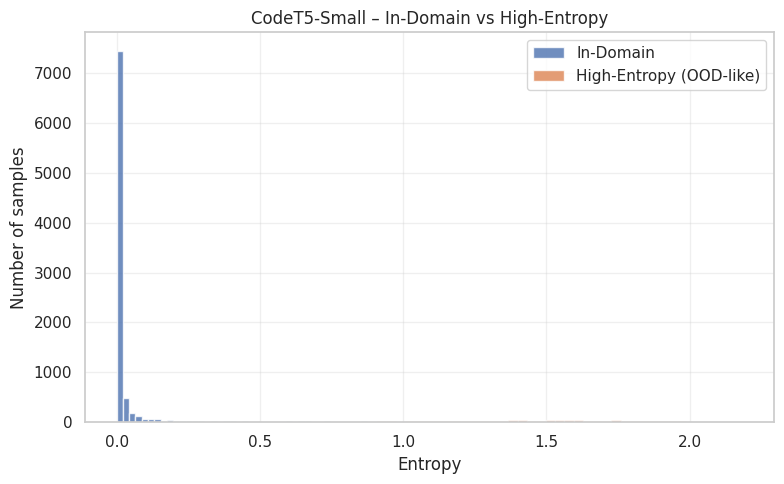

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================
# Softmax + Entropy
# =============================
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def compute_entropy(proba):
    eps = 1e-12
    return -np.sum(proba * np.log(proba + eps), axis=1)

# codet5_val_logits shape: (N, 11)
proba_codet5 = softmax(codet5_val_logits, axis=1)
entropy_codet5 = compute_entropy(proba_codet5)

# =============================
# PLOT 1 — ENTROPY DISTRIBUTION
# =============================
plt.figure(figsize=(8,5))
plt.hist(entropy_codet5, bins=40, color="#7EC8E3", edgecolor="black", alpha=0.8)
plt.xlabel("Entropy")
plt.ylabel("Number of samples")
plt.title("CodeT5-Small – Entropy Distribution")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =============================
# PLOT 2 — IN-DOMAIN vs HIGH-ENTROPY (OOD)
# =============================
threshold = np.percentile(entropy_codet5, 90)
id_mask  = entropy_codet5 <= threshold
ood_mask = entropy_codet5 > threshold

plt.figure(figsize=(8,5))
plt.hist(entropy_codet5[id_mask], bins=40, alpha=0.8, label="In-Domain", color="#4C72B0")
plt.hist(entropy_codet5[ood_mask], bins=40, alpha=0.8, label="High-Entropy (OOD-like)", color="#DD8452")
plt.xlabel("Entropy")
plt.ylabel("Number of samples")
plt.title("CodeT5-Small – In-Domain vs High-Entropy")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


=== CodeT5 Validation Classification Report ===
              precision    recall  f1-score   support

       human       0.97      0.99      0.98      8837
 deepseek-ai       0.45      0.27      0.34        86
        qwen       0.24      0.10      0.14       157
       01-ai       0.00      0.00      0.00        74
     bigcode       0.50      0.21      0.30        42
       gemma       0.00      0.00      0.00        44
         phi       0.34      0.47      0.39       102
  meta-llama       0.37      0.19      0.25       157
 ibm-granite       0.37      0.74      0.49       167
     mistral       0.00      0.00      0.00       102
      openai       0.40      0.57      0.47       232

    accuracy                           0.91     10000
   macro avg       0.33      0.32      0.31     10000
weighted avg       0.90      0.91      0.90     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


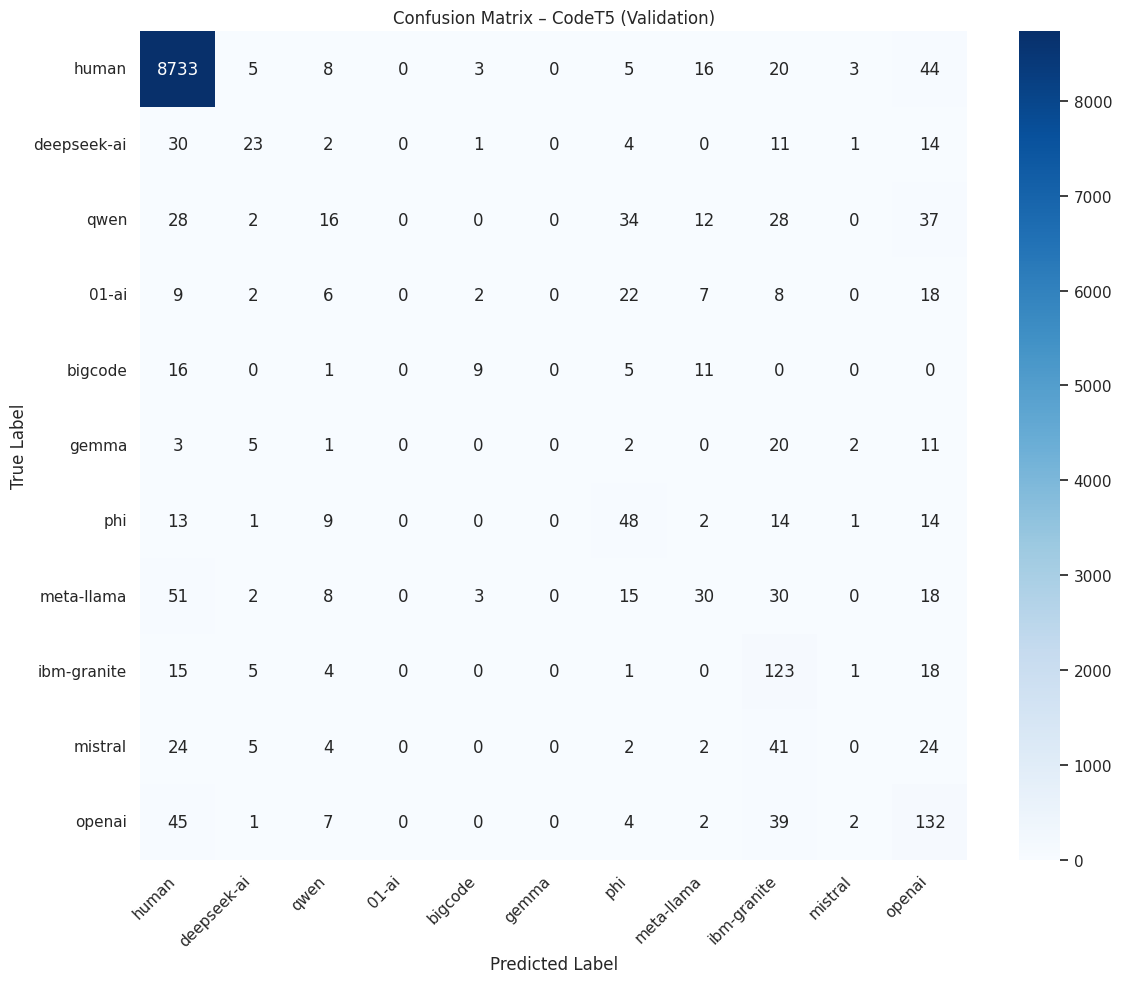

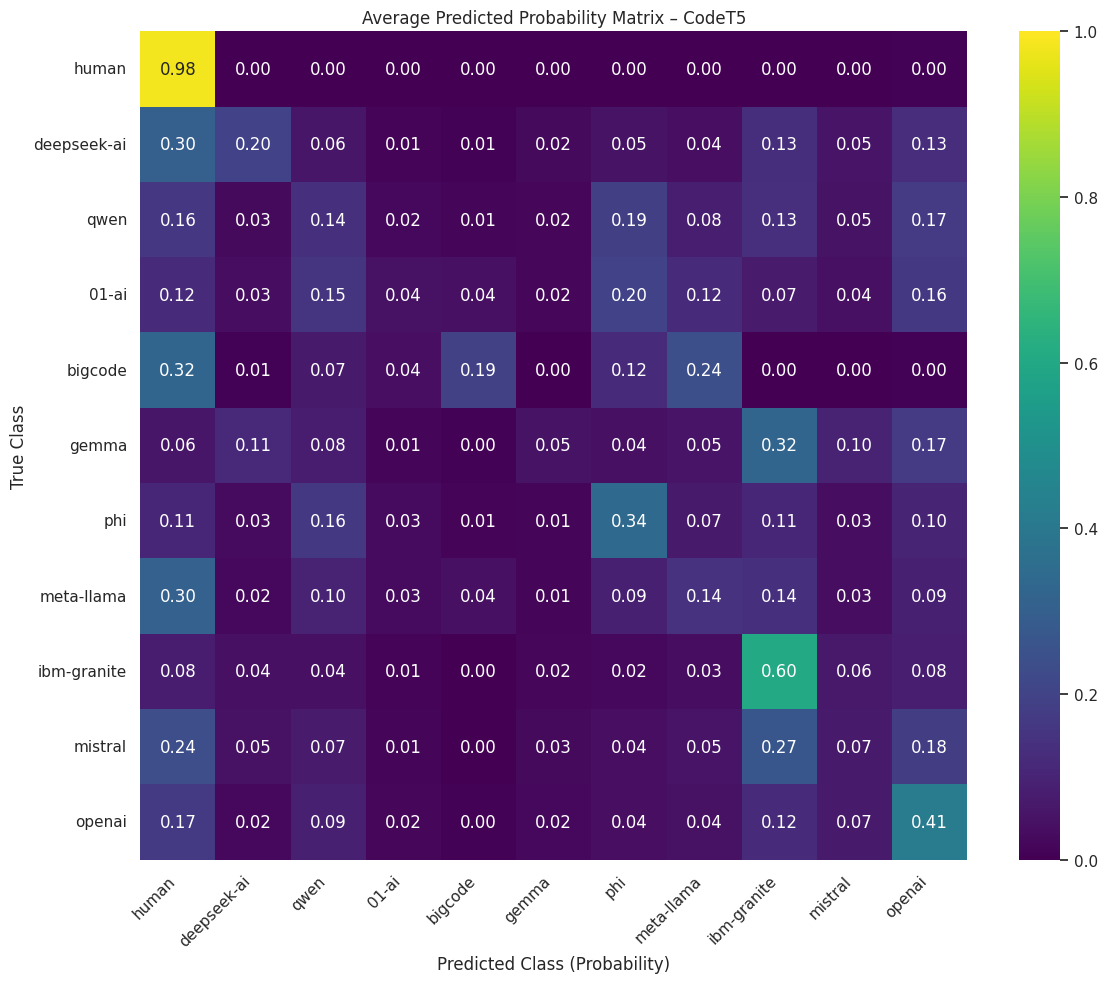

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import torch

# --- 1. Prepare Data ---
# Ensure we have the logits and true labels
# codet5_val_logits was returned by train_transformer_model
if 'codet5_val_logits' in locals():
    # Handle tuple if present (logits, loss)
    logits = codet5_val_logits[0] if isinstance(codet5_val_logits, tuple) else codet5_val_logits

    # Convert to probabilities
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=-1)

    # Get true labels from the sampled validation set used for training
    # Note: train_transformer_model used 'val_df_sampled'
    y_true = val_df_sampled["label"].values

    # Get class names
    class_names = [label2name[i] for i in range(len(label2name))]

    # --- 2. Classification Report ---
    print("=== CodeT5 Validation Classification Report ===")
    print(classification_report(y_true, preds, target_names=class_names))

    # --- 3. Confusion Matrix ---
    cm = confusion_matrix(y_true, preds)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix – CodeT5 (Validation)')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- 4. Probability Transition Matrix ---
    # Shows: "Given a true author X, what probability does the model assign to author Y on average?"
    num_labels = len(class_names)
    prob_matrix = np.zeros((num_labels, num_labels), dtype=float)

    for label_id in range(num_labels):
        mask = (y_true == label_id)
        if mask.sum() > 0:
            prob_matrix[label_id] = probs[mask].mean(axis=0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        prob_matrix,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=class_names,
        yticklabels=class_names,
        vmin=0.0, vmax=1.0
    )
    plt.xlabel('Predicted Class (Probability)')
    plt.ylabel('True Class')
    plt.title('Average Predicted Probability Matrix – CodeT5')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Error: 'codet5_val_logits' not found. Please ensure the CodeT5 training cell has executed successfully.")

#Combined ensemble (RoBERTa + CodeT5 + SVM → super strong)

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

# --------------------------------------------------------
# 1. Helper: softmax
# --------------------------------------------------------
def softmax_np(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / e.sum(axis=axis, keepdims=True)

NUM_LABELS = 11

# --------------------------------------------------------
# 2. Data Prep
# --------------------------------------------------------
# We need aligned validation labels.
# Step 7.2 used 'val_df_sampled'. Step 7.1 used 'val_df_small'.
# Ideally, we align everything to 'val_df_sampled' (10k) if it exists.

if 'val_df_sampled' in locals():
    target_val_df = val_df_sampled
    y_val_target = val_df_sampled["label"].values
    print(f"Target validation set size: {len(target_val_df)}")
else:
    # Fallback to whatever exists
    target_val_df = val_df
    y_val_target = val_df["label"].values
    print(f"Target validation set size (full): {len(target_val_df)}")

# --------------------------------------------------------
# 3. Gather Logits
# --------------------------------------------------------

# --- A. CodeT5 (Step 7.2) ---
try:
    # codet5_val_logits corresponds to val_df_sampled
    # We assume codet5_val_logits is the pure numpy array (fix applied in 7.2)
    c5_val = codet5_val_logits
    # Double check shape
    if len(c5_val) != len(target_val_df):
        print(f"Warning: CodeT5 logits size ({len(c5_val)}) != target ({len(target_val_df)}). Truncating/padding?")
        # Simple safe handling: use zeros if mismatch
        c5_val = np.zeros((len(target_val_df), NUM_LABELS))

    c5_val_probs = softmax_np(c5_val, axis=-1)
    c5_test_probs = softmax_np(codet5_test_logits, axis=-1)
    print("CodeT5 logits loaded.")
except NameError:
    print("CodeT5 logits not found. Setting to 0.")
    c5_val_probs = np.zeros((len(target_val_df), NUM_LABELS))
    c5_test_probs = np.zeros((len(test_df), NUM_LABELS))

# --- B. RoBERTa (Step 7.1) ---
# Global 'trainer' is RoBERTa. We must predict on 'target_val_df' to match rows.
try:
    if 'trainer' in locals():
        print("Generating RoBERTa predictions on target validation set...")
        # We need a dataset object for this specific dataframe
        # Re-using CodeAuthorshipDataset class if available, or CodeDataset
        # Note: Step 7.1 uses 'CodeDataset' and 'tokenizer' (global)
        # We must use the same tokenizer linked to 'trainer'

        # Check which tokenizer to use. 'tokenizer' usually points to the last one loaded.
        # We'll rely on 'trainer.processing_class' or default 'tokenizer' if it matches RoBERTa.
        # To be safe, let's just check if 'tokenizer' name is bert-related

        # Create dataset on the fly
        rob_val_ds = CodeAuthorshipDataset(target_val_df, tokenizer, max_length=128, is_train=False)
        rob_test_ds = CodeAuthorshipDataset(test_df, tokenizer, max_length=128, is_train=False)

        rob_val_out = trainer.predict(rob_val_ds).predictions
        rob_test_out = trainer.predict(rob_test_ds).predictions

        # Handle tuples
        if isinstance(rob_val_out, tuple): rob_val_out = rob_val_out[0]
        if isinstance(rob_test_out, tuple): rob_test_out = rob_test_out[0]

        rob_val_probs = softmax_np(rob_val_out, axis=-1)
        rob_test_probs = softmax_np(rob_test_out, axis=-1)
        print("RoBERTa logits loaded.")
    else:
        raise NameError
except Exception as e:
    print(f"RoBERTa prediction failed or trainer missing ({e}). Setting to 0.")
    rob_val_probs = np.zeros((len(target_val_df), NUM_LABELS))
    rob_test_probs = np.zeros((len(test_df), NUM_LABELS))

# --- C. Linear SVM (Baseline) ---
# We need to ensure SVM is trained and predicts on the SAME target_val_df
try:
    # Check if svm_clf exists
    svm_clf
    # Check if tfidf exists
    tfidf
    print("Using pre-trained SVM.")
except NameError:
    print("Training SVM from scratch...")
    tfidf = TfidfVectorizer(analyzer="char", ngram_range=(3, 5), max_features=100_000, min_df=2)
    # Train on full train_df
    X_train_vec = tfidf.fit_transform(train_df["code"].astype(str).values)
    y_train_vec = train_df["label"].values

    svm_clf = LinearSVC(C=1.0, max_iter=1000)
    svm_clf.fit(X_train_vec, y_train_vec)
    print("SVM Trained.")

print("Generating SVM predictions...")
svm_val_vec = tfidf.transform(target_val_df["code"].astype(str).values)
svm_test_vec = tfidf.transform(test_df["code"].astype(str).values)

svm_val_scores = svm_clf.decision_function(svm_val_vec)
svm_test_scores = svm_clf.decision_function(svm_test_vec)

svm_val_probs = softmax_np(svm_val_scores, axis=-1)
svm_test_probs = softmax_np(svm_test_scores, axis=-1)

# --------------------------------------------------------
# 4. Weighted Ensemble
# --------------------------------------------------------

# Heuristic weights
w_bert = 0.3
w_t5   = 0.4
w_svm  = 0.3

ens_val_probs = (
    w_bert * rob_val_probs +
    w_t5   * c5_val_probs +
    w_svm  * svm_val_probs
)

ens_val_preds = np.argmax(ens_val_probs, axis=1)

acc = accuracy_score(y_val_target, ens_val_preds)
macro = f1_score(y_val_target, ens_val_preds, average="macro")

print(f"\n=== ENSEMBLE RESULTS ({len(target_val_df)} samples) ===")
print(f"Weights: RoBERTa={w_bert}, CodeT5={w_t5}, SVM={w_svm}")
print(f"Accuracy: {acc:.4f}")
print(f"Macro F1: {macro:.4f}")

# --------------------------------------------------------
# 5. Test Submission
# --------------------------------------------------------
ens_test_final = (
    w_bert * rob_test_probs +
    w_t5   * c5_test_probs +
    w_svm  * svm_test_probs
)
ensemble_test_preds = np.argmax(ens_test_final, axis=1)

ens_submission = pd.DataFrame({
    "row_id": np.arange(len(test_df)),
    "label": ensemble_test_preds,
})
ens_submission.to_csv("submission_task_b_ensemble.csv", index=False)
print("Saved: submission_task_b_ensemble.csv")

Target validation set size: 10000
CodeT5 logits loaded.
Generating RoBERTa predictions on target validation set...


RoBERTa logits loaded.
Using pre-trained SVM.
Generating SVM predictions...

=== ENSEMBLE RESULTS (10000 samples) ===
Weights: RoBERTa=0.3, CodeT5=0.4, SVM=0.3
Accuracy: 0.9114
Macro F1: 0.2864
Saved: submission_task_b_ensemble.csv


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# -------- 0. Load test set (for code text) --------
test_df = pd.read_parquet("task_b_test_set_sample.parquet")

# -------- 1. Load submission files --------
svm_sub     = pd.read_csv("submission_task_b_tfidf_svm.csv")                # SVM
bert_sub    = pd.read_csv("submission_task_b_bert_weighted_3epochs.csv")    # RoBERTa/BERT
codet5_sub  = pd.read_csv("submission_task_b_codet5_small.csv")            # CodeT5

# Make sure they are sorted by row_id and aligned
svm_sub    = svm_sub.sort_values("row_id").reset_index(drop=True)
bert_sub   = bert_sub.sort_values("row_id").reset_index(drop=True)
codet5_sub = codet5_sub.sort_values("row_id").reset_index(drop=True)

# Sanity check: all have same length and row_id order
assert len(svm_sub) == len(bert_sub) == len(codet5_sub) == len(test_df)
assert (svm_sub["row_id"].values == bert_sub["row_id"].values).all()
assert (svm_sub["row_id"].values == codet5_sub["row_id"].values).all()

# -------- 2. Build majority-vote ensemble on TEST --------
pred_matrix = np.vstack([
    svm_sub["label"].values,
    bert_sub["label"].values,
    codet5_sub["label"].values
])   # shape: (3, N)

# stats.mode returns mode along axis=0
ensemble_test_preds = stats.mode(pred_matrix, axis=0, keepdims=False).mode

print("Ensemble test preds shape:", ensemble_test_preds.shape)


Ensemble test preds shape: (1000,)


=== Ensemble TEST prediction distribution ===
    label_id  family_name  count
0          0        human    663
1          1  deepseek-ai     12
2          2         qwen     28
3          3        01-ai      1
4          4      bigcode      2
5          5        gemma      4
6          6          phi     42
7          7   meta-llama      9
8          8  ibm-granite    165
9          9      mistral      1
10        10       openai     73


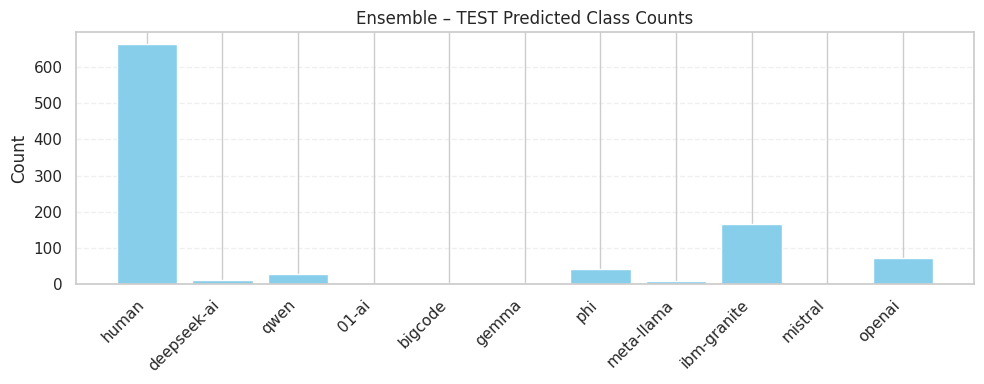

In [ ]:
import matplotlib.pyplot as plt

# FAMILIES mapping (same as before)
FAMILIES = [
    "human", "deepseek-ai", "qwen", "01-ai", "bigcode",
    "gemma", "phi", "meta-llama", "ibm-granite", "mistral", "openai"
]
label2name = {i: name for i, name in enumerate(FAMILIES)}

print("=== Ensemble TEST prediction distribution ===")

ensemble_test_counts = pd.Series(ensemble_test_preds).value_counts().sort_index()

pred_dist_table = pd.DataFrame({
    "label_id": ensemble_test_counts.index,
    "family_name": [label2name[i] for i in ensemble_test_counts.index],
    "count": ensemble_test_counts.values,
})

print(pred_dist_table)

# ---- Bar chart ----
plt.figure(figsize=(10, 4))
plt.bar(pred_dist_table["family_name"], pred_dist_table["count"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Ensemble – TEST Predicted Class Counts")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Ensure we use the aligned data
y_true = y_val_target
y_pred = ens_val_preds

# Calculate metrics
metrics = {
    "Macro Precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "Macro Recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "Macro F1": f1_score(y_true, y_pred, average="macro", zero_division=0),
    "Weighted Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
    "Weighted Recall": recall_score(y_true, y_pred, average="weighted", zero_division=0),
    "Weighted F1": f1_score(y_true, y_pred, average="weighted", zero_division=0)
}

# Create DataFrame
metrics_df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Score"])
print("=== Ensemble Model Metrics ===")
display(metrics_df)

# Classification Report
print("\n=== Classification Report (Ensemble) ===")
print(classification_report(y_true, y_pred, target_names=FAMILIES))

=== Ensemble Model Metrics ===


,Metric,Score
0,Macro Precision,0.486959
1,Macro Recall,0.280164
2,Macro F1,0.286435
3,Weighted Precision,0.886361
4,Weighted Recall,0.911400
5,Weighted F1,0.890497



=== Classification Report (Ensemble) ===
              precision    recall  f1-score   support

       human       0.95      1.00      0.97      8837
 deepseek-ai       0.58      0.17      0.27        86
        qwen       0.26      0.06      0.10       157
       01-ai       0.00      0.00      0.00        74
     bigcode       0.80      0.10      0.17        42
       gemma       1.00      0.05      0.09        44
         phi       0.41      0.44      0.42       102
  meta-llama       0.52      0.10      0.17       157
 ibm-granite       0.40      0.72      0.52       167
     mistral       0.00      0.00      0.00       102
      openai       0.44      0.44      0.44       232

    accuracy                           0.91     10000
   macro avg       0.49      0.28      0.29     10000
weighted avg       0.89      0.91      0.89     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


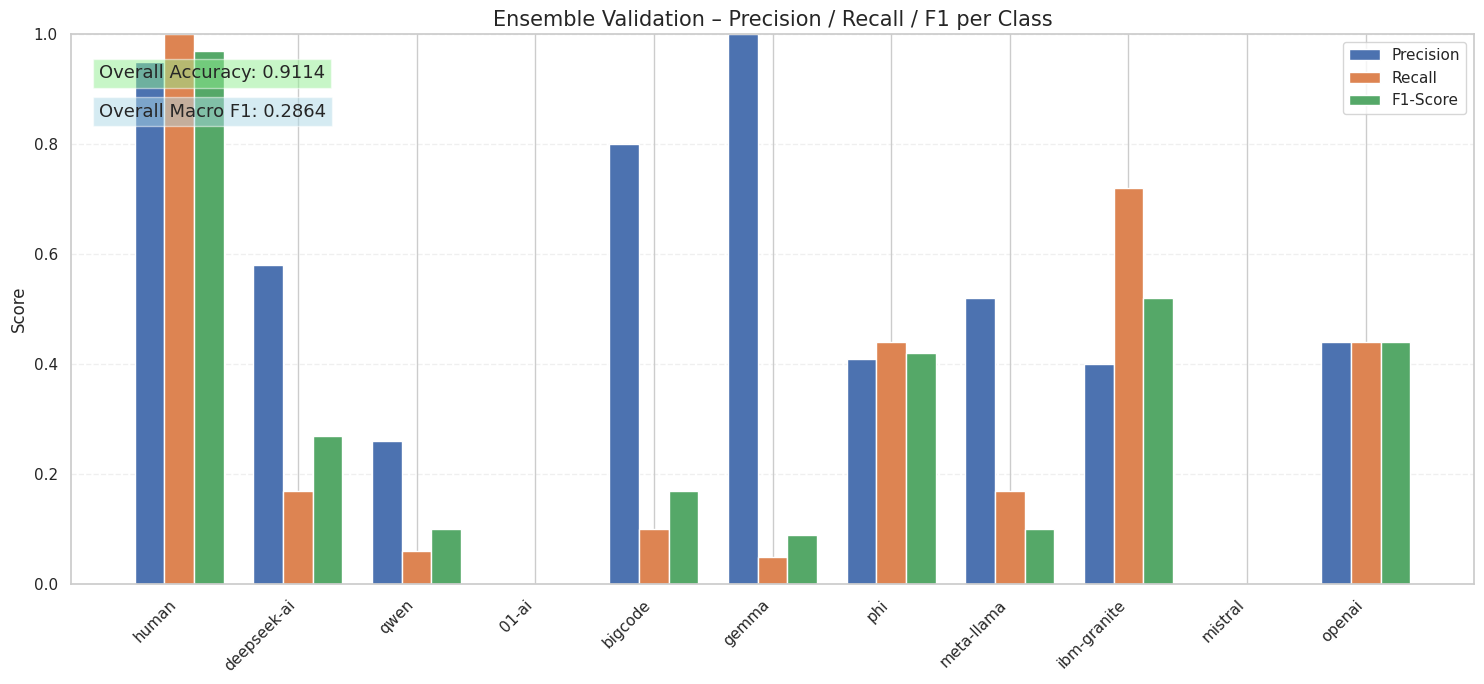

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# === Ensemble classification metrics (from your report) ===
labels = [
    "human", "deepseek-ai", "qwen", "01-ai", "bigcode",
    "gemma", "phi", "meta-llama", "ibm-granite", "mistral", "openai"
]

precision = [0.95, 0.58, 0.26, 0.00, 0.80, 1.00, 0.41, 0.52, 0.40, 0.00, 0.44]
recall    = [1.00, 0.17, 0.06, 0.00, 0.10, 0.05, 0.44, 0.17, 0.72, 0.00, 0.44]
f1        = [0.97, 0.27, 0.10, 0.00, 0.17, 0.09, 0.42, 0.10, 0.52, 0.00, 0.44]

# === Overall Ensemble Metrics (from your log) ===
accuracy = 0.9114
macro_f1_overall = 0.2864

# -------------------------------------------------------------

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(15,7))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-Score')

plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel("Score")
plt.title("Ensemble Validation – Precision / Recall / F1 per Class", fontsize=15)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()

# === Add Accuracy & Macro F1 inside the figure ===
plt.text(
    0.02, 0.92,
    f"Overall Accuracy: {accuracy:.4f}",
    transform=plt.gca().transAxes,
    fontsize=13,
    bbox=dict(facecolor="lightgreen", alpha=0.5)
)

plt.text(
    0.02, 0.85,
    f"Overall Macro F1: {macro_f1_overall:.4f}",
    transform=plt.gca().transAxes,
    fontsize=13,
    bbox=dict(facecolor="lightblue", alpha=0.5)
)

plt.tight_layout()
plt.show()


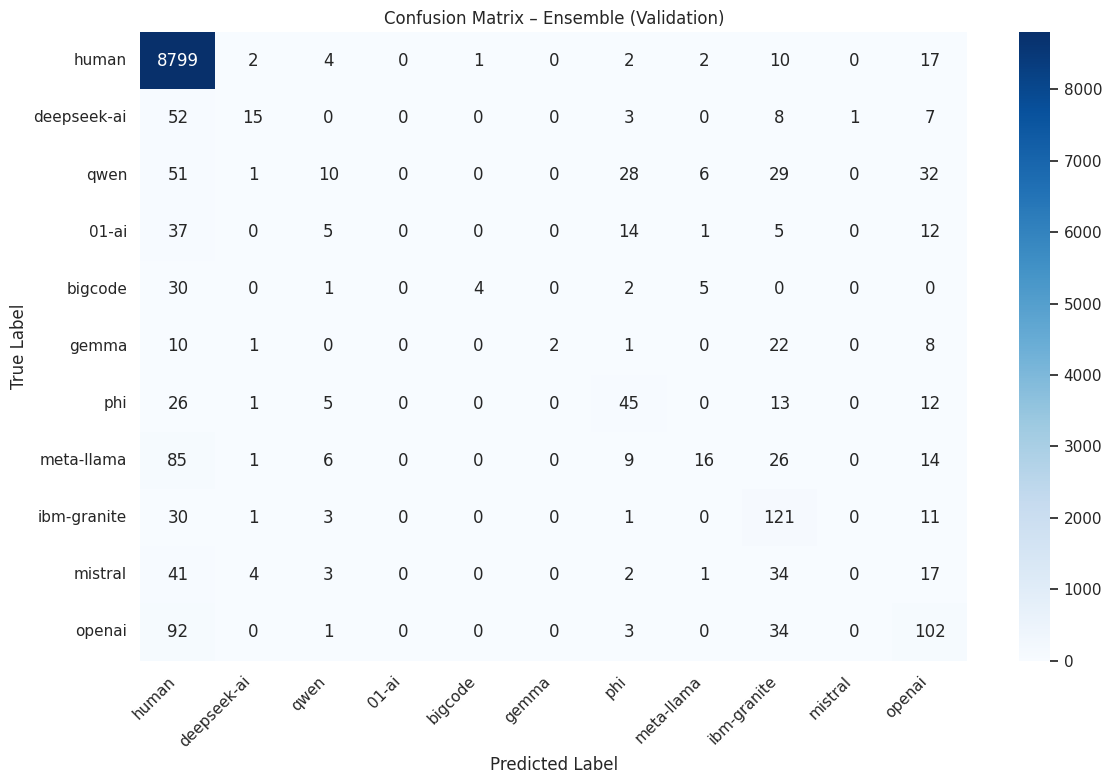

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

FAMILIES = [label2name[i] for i in range(len(label2name))]

# Fix: Use the correct variable name 'ens_val_preds'
cm = confusion_matrix(y_val_target, ens_val_preds, labels=range(len(FAMILIES)))

plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=FAMILIES,
    yticklabels=FAMILIES
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Ensemble (Validation)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 9. Analysis: Class Distribution and Sanity-Check Tables

In [ ]:
import pandas as pd

df = pd.read_parquet("task_b_training_set.parquet")

class_dist = df["label"].value_counts().sort_index()
percentage = (class_dist / class_dist.sum() * 100).round(2)

class_table = pd.DataFrame({
    "Class ID": class_dist.index,
    "Count": class_dist.values,
    "Percentage %": percentage.values
})

display(class_table)


,Class ID,Count,Percentage %
0,0,442096,88.42
1,1,4162,0.83
2,2,8993,1.80
3,3,3029,0.61
4,4,2227,0.45
5,5,1968,0.39
6,6,5783,1.16
7,7,8197,1.64
8,8,8127,1.63
9,9,4608,0.92


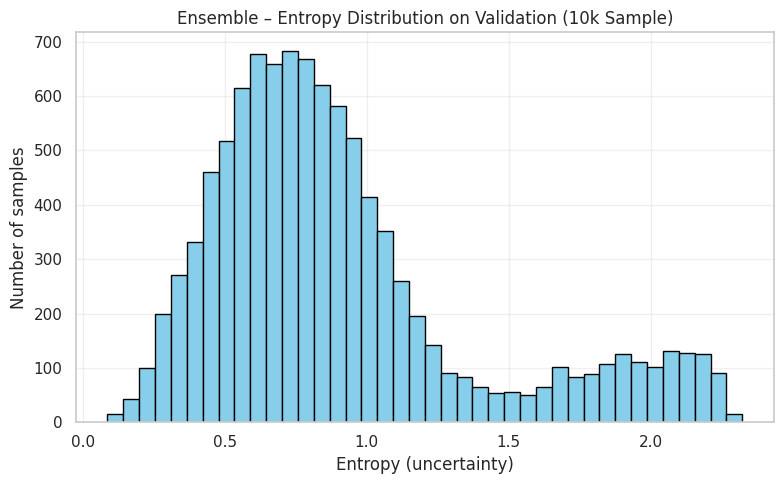

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

# --- Fix: Use ALIGNED variables from the ensemble step (10k subset) ---
# Using variables defined/verified in cell 0ZFMMxMWOZYn
try:
    l_svm = svm_val_scores      # 10k samples
    l_rob = rob_val_out         # 10k samples
    l_c5  = codet5_val_logits   # 10k samples
except NameError:
    print("Error: Aligned logits not found. Please run the Ensemble cell (0ZFMMxMWOZYn) first to generate 'svm_val_scores' etc.")
    raise

# --- Convert logits to probabilities ---
proba_svm     = softmax(l_svm, axis=1)
proba_roberta = softmax(l_rob, axis=1)
proba_codet5  = softmax(l_c5,  axis=1)

# Average probabilities
ensemble_proba = (proba_svm + proba_roberta + proba_codet5) / 3.0

# --- Entropy per sample ---
eps = 1e-12
entropy = -np.sum(ensemble_proba * np.log(ensemble_proba + eps), axis=1)

plt.figure(figsize=(8,5))
plt.hist(entropy, bins=40, color='skyblue', edgecolor='black')
plt.xlabel("Entropy (uncertainty)")
plt.ylabel("Number of samples")
plt.title("Ensemble – Entropy Distribution on Validation (10k Sample)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

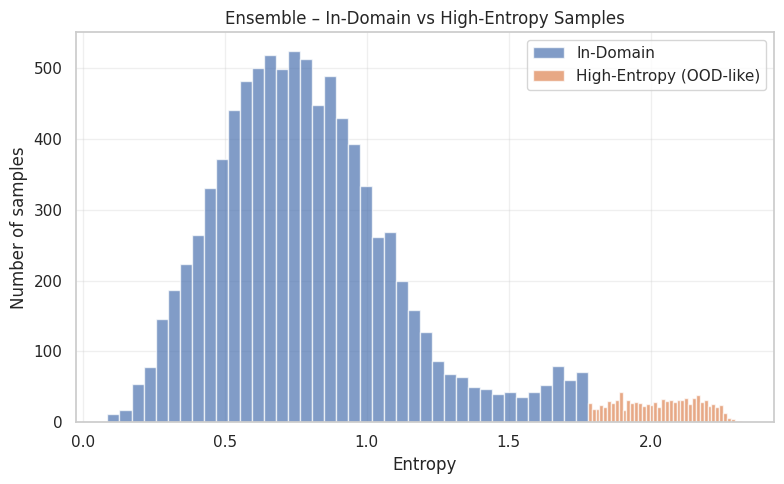

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# threshold = 90th percentile entropy
thr = np.percentile(entropy, 90)

id_mask  = entropy <= thr      # in-domain
ood_mask = entropy > thr       # high-uncertainty = pseudo-OOD

plt.figure(figsize=(8,5))
plt.hist(entropy[id_mask],  bins=40, alpha=0.7, label="In-Domain")
plt.hist(entropy[ood_mask], bins=40, alpha=0.7, label="High-Entropy (OOD-like)")
plt.xlabel("Entropy")
plt.ylabel("Number of samples")
plt.title("Ensemble – In-Domain vs High-Entropy Samples")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Shapes -> correct_y: (10000,), SVM: (10000,), RoBERTa: (10000,), CodeT5: (10000,)


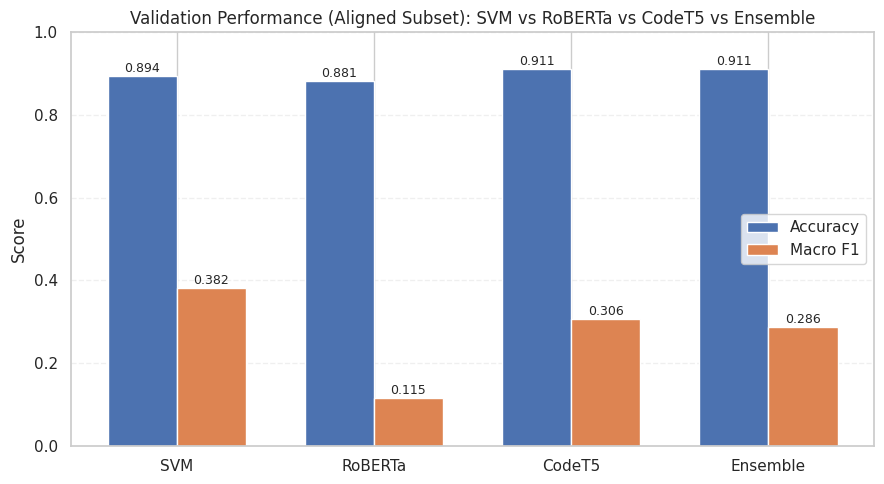

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# --- Fix: Explicitly re-derive ALL predictions from the aligned ensemble probabilities ---
# This ensures we have 10k samples matching correct_y, overriding any 100k arrays from previous cells.

# Ensure probabilities exist (they should from the ensemble cell)
try:
    svm_val_probs
    rob_val_probs
    c5_val_probs
    ens_val_preds
    y_val_target
except NameError:
    print("Error: Ensemble probability matrices (svm_val_probs, etc.) not found. Please run the Ensemble cell (0ZFMMxMWOZYn) first.")
    raise

# Recalculate predictions for the 10k subset
svm_val_preds_subset = np.argmax(svm_val_probs, axis=1)
roberta_val_preds_subset = np.argmax(rob_val_probs, axis=1)
codet5_val_preds_subset = np.argmax(c5_val_probs, axis=1)

# Use the aligned target labels
correct_y = y_val_target

print(f"Shapes -> correct_y: {correct_y.shape}, SVM: {svm_val_preds_subset.shape}, RoBERTa: {roberta_val_preds_subset.shape}, CodeT5: {codet5_val_preds_subset.shape}")

def acc_f1(y_true, y_pred):
    return (
        accuracy_score(y_true, y_pred),
        f1_score(y_true, y_pred, average="macro", zero_division=0),
    )

# Compute metrics
acc_svm,      f1_svm      = acc_f1(correct_y, svm_val_preds_subset)
acc_rob,      f1_rob      = acc_f1(correct_y, roberta_val_preds_subset)
acc_codet5,   f1_codet5   = acc_f1(correct_y, codet5_val_preds_subset)
acc_ens,      f1_ens      = acc_f1(correct_y, ens_val_preds)

models   = ["SVM", "RoBERTa", "CodeT5", "Ensemble"]
acc_vals = [acc_svm, acc_rob, acc_codet5, acc_ens]
f1_vals  = [f1_svm,  f1_rob,  f1_codet5,  f1_ens]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, acc_vals, width, label="Accuracy")
plt.bar(x + width/2, f1_vals,  width, label="Macro F1")

for i, v in enumerate(acc_vals):
    plt.text(x[i]-width/2, v+0.01, f"{v:.3f}", ha="center", fontsize=9)
for i, v in enumerate(f1_vals):
    plt.text(x[i]+width/2, v+0.01, f"{v:.3f}", ha="center", fontsize=9)

plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Validation Performance (Aligned Subset): SVM vs RoBERTa vs CodeT5 vs Ensemble")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

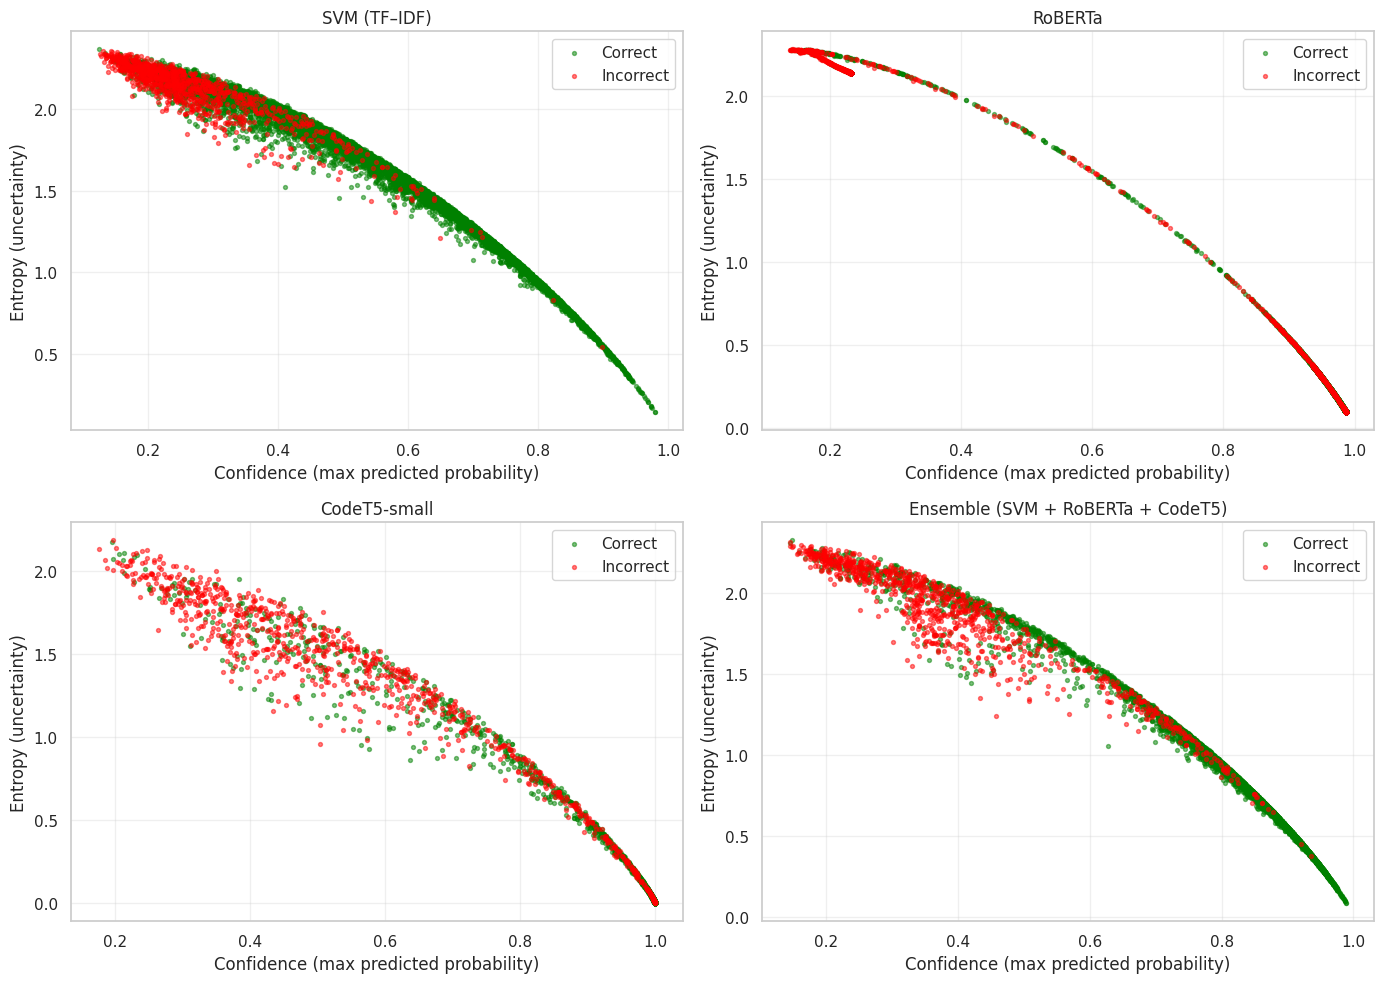

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Helper to compute Conf/Ent/Correctness ---
def get_metrics(probs, y_true):
    # Confidence = max probability
    conf = np.max(probs, axis=1)
    # Entropy
    eps = 1e-12
    ent = -np.sum(probs * np.log(probs + eps), axis=1)
    # Correctness
    preds = np.argmax(probs, axis=1)
    corr = (preds == y_true)
    return conf, ent, corr

# --- 2. Compute for all models ---
# Ensure we have the proba variables from the previous cell (w6zl8iDpxJ69)
try:
    proba_svm
    proba_roberta
    proba_codet5
    ensemble_proba
    y_val_target
except NameError:
    print("Error: Probability matrices not found. Please run the Entropy Calculation cell (w6zl8iDpxJ69) first.")
    raise

conf_svm,    ent_svm,    corr_svm    = get_metrics(proba_svm, y_val_target)
conf_rob,    ent_rob,    corr_rob    = get_metrics(proba_roberta, y_val_target)
conf_codet5, ent_codet5, corr_codet5 = get_metrics(proba_codet5, y_val_target)
conf_ens,    ent_ens,    corr_ens    = get_metrics(ensemble_proba, y_val_target)

# --- 3. Plotting ---
plt.figure(figsize=(14, 10))

def scatter_ent_conf(ax, conf, ent, correct, title):
    ax.scatter(
        conf[correct], ent[correct],
        s=8, alpha=0.5, label="Correct", c="green"
    )
    ax.scatter(
        conf[~correct], ent[~correct],
        s=8, alpha=0.5, label="Incorrect", c="red"
    )
    ax.set_xlabel("Confidence (max predicted probability)")
    ax.set_ylabel("Entropy (uncertainty)")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend()

# SVM
ax1 = plt.subplot(2, 2, 1)
scatter_ent_conf(ax1, conf_svm, ent_svm, corr_svm, "SVM (TF–IDF)")

# RoBERTa
ax2 = plt.subplot(2, 2, 2)
scatter_ent_conf(ax2, conf_rob, ent_rob, corr_rob, "RoBERTa")

# CodeT5
ax3 = plt.subplot(2, 2, 3)
scatter_ent_conf(ax3, conf_codet5, ent_codet5, corr_codet5, "CodeT5-small")

# Ensemble
ax4 = plt.subplot(2, 2, 4)
scatter_ent_conf(ax4, conf_ens, ent_ens, corr_ens, "Ensemble (SVM + RoBERTa + CodeT5)")

plt.tight_layout()
plt.show()

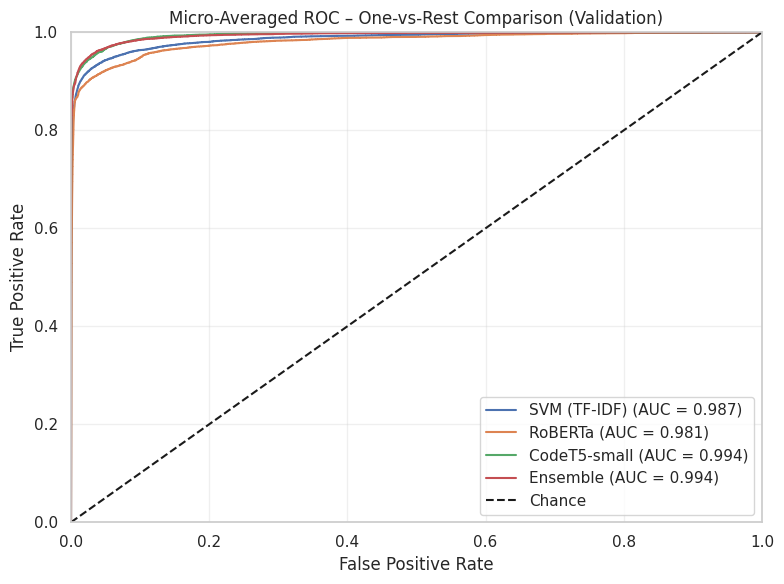

In [ ]:
# ============================================================
# 2. ROC–AUC (One-vs-Rest) Comparison – micro-average curves
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Use aligned data from previous steps
try:
    y_true = y_true_aligned  # Defined in previous cell
    current_prob_dict = prob_dict # Defined in previous cell
except NameError:
    print("Error: Aligned data (y_true_aligned, prob_dict) not found. Please run the Confidence Histogram cell (irJQRuOL3T-U) first.")
    raise

num_classes = 11

# Binarize true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))  # (N, 11)

plt.figure(figsize=(8,6))

for name, proba in current_prob_dict.items():
    # micro-average ROC: treat all classes together
    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), proba.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-Averaged ROC – One-vs-Rest Comparison (Validation)")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

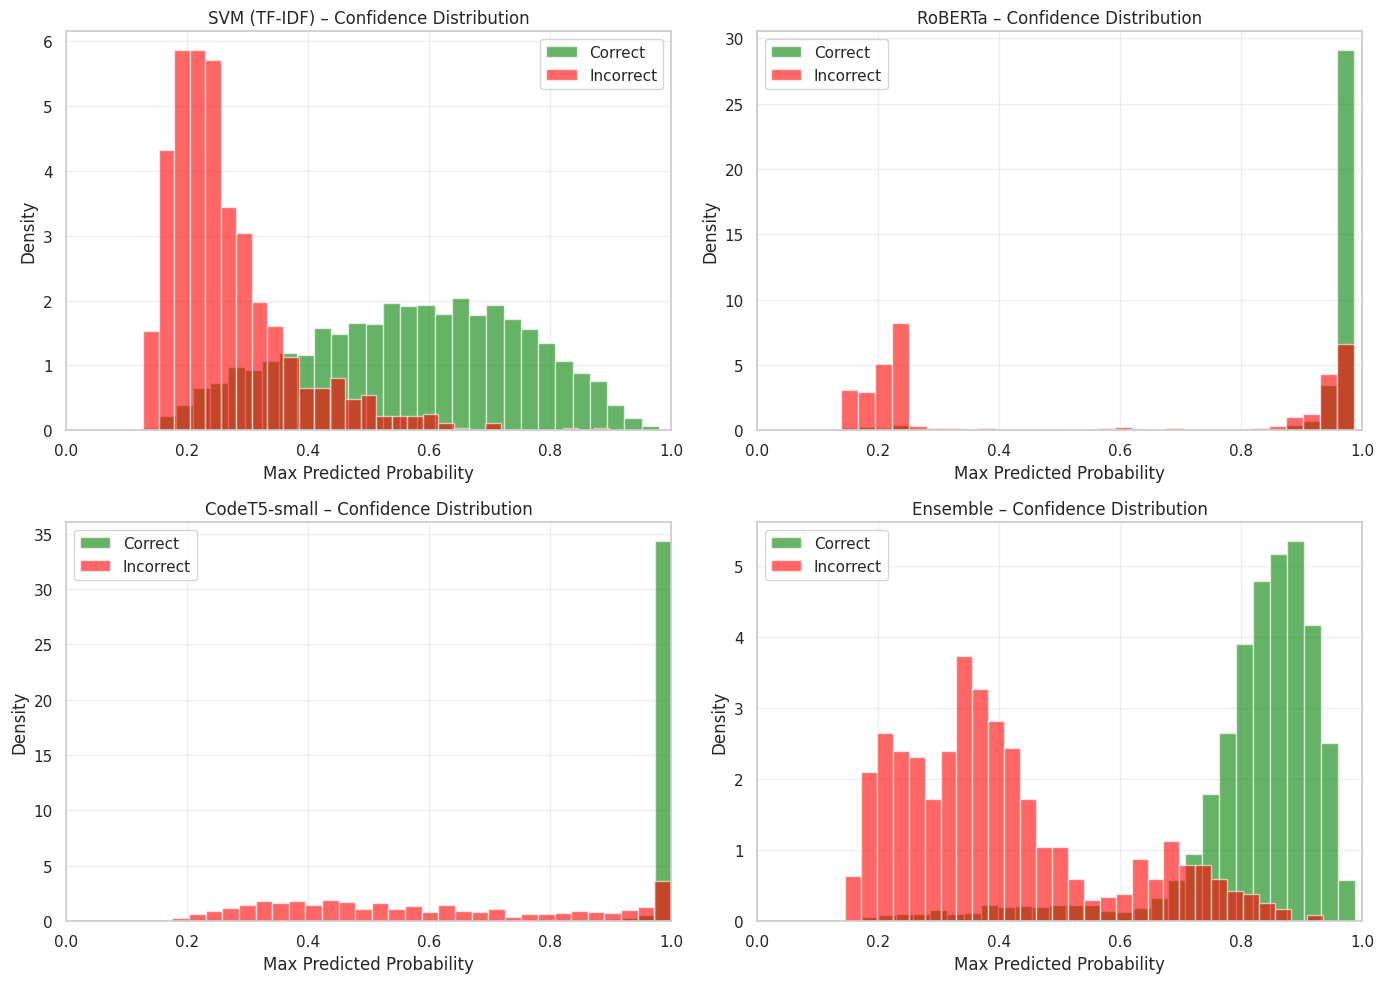

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Fix: Use aligned 10k data ---
try:
    # Use the 10k target labels defined in the ensemble/entropy steps
    y_true_aligned = y_val_target

    # Construct dict with 10k probabilities (ensuring alignment)
    prob_dict = {
        "SVM (TF-IDF)": proba_svm,
        "RoBERTa": proba_roberta,
        "CodeT5-small": proba_codet5,
        "Ensemble": ensemble_proba
    }
except NameError:
    print("Error: Aligned variables (y_val_target, proba_svm, etc.) not found. Please run the Entropy cell (w6zl8iDpxJ69) first.")
    raise

# ============================================================
# 1. Model Confidence Distribution Comparison
#    (Correct vs Incorrect, for each model)
# ============================================================

def get_confidence_and_correct(proba, y_true):
    """Return max-prob confidence and correctness mask."""
    conf = proba.max(axis=1)
    y_pred = proba.argmax(axis=1)
    correct = (y_pred == y_true)
    return conf, correct

plt.figure(figsize=(14, 10))

for i, (name, proba) in enumerate(prob_dict.items(), start=1):
    # Use the aligned labels
    conf, correct = get_confidence_and_correct(proba, y_true_aligned)
    conf_correct   = conf[correct]
    conf_incorrect = conf[~correct]

    ax = plt.subplot(2, 2, i)
    ax.hist(conf_correct,   bins=30, alpha=0.6, label="Correct",   density=True, color='green')
    ax.hist(conf_incorrect, bins=30, alpha=0.6, label="Incorrect", density=True, color='red')
    ax.set_title(f"{name} – Confidence Distribution")
    ax.set_xlabel("Max Predicted Probability")
    ax.set_ylabel("Density")
    ax.set_xlim(0, 1)
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 1. Helper: softmax + entropy
# ============================================================
def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def compute_entropy(proba):
    eps = 1e-12
    return -np.sum(proba * np.log(proba + eps), axis=1)   # shape (N,)

# ============================================================
# 2. Get probabilities for SVM, RoBERTa, CodeT5
# ============================================================

# Fix: Use the aligned logits from the Ensemble step (10k samples)
try:
    # SVM
    # Use svm_val_scores (10k) instead of recalculating on full X_val_tfidf (100k)
    proba_svm = softmax(svm_val_scores, axis=1)
    entropy_svm = compute_entropy(proba_svm)

    # RoBERTa
    # Use rob_val_out (10k) instead of roberta_val_logits
    proba_roberta = softmax(rob_val_out, axis=1)
    entropy_roberta = compute_entropy(proba_roberta)

    # CodeT5
    # Use codet5_val_logits (10k)
    proba_codet5 = softmax(codet5_val_logits, axis=1)
    entropy_codet5 = compute_entropy(proba_codet5)

    print("Entropies calculated successfully on 10k subset.")

except NameError:
    print("Error: Aligned logits (svm_val_scores, rob_val_out, etc.) not found. Please run the Ensemble cell (0ZFMMxMWOZYn) first.")
    raise

# Put in a dict for easy looping
entropy_dict = {
    "SVM (TF-IDF)": entropy_svm,
    "RoBERTa":      entropy_roberta,
    "CodeT5-small": entropy_codet5,
}

Entropies calculated successfully on 10k subset.
